# Init Tdx 

In [1]:
# import logging
import sys

# stdout=sys.stdout
sys.path.append('../../')
import os
import random
import time

import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf
# sys.stdout=stdout
import numpy as np
# import numpy as np
import pandas as pd
from JohnsonUtil import commonTips as cct
from JSONData import sina_data
from JSONData import tdx_data_Day as tdd
from mplfinance.original_flavor import candlestick_ohlc

# from JSONData import tdx_hdf5_api as h5a

%matplotlib widget
plt.rc('font', family='SimHei', size=13)
matplotlib.get_backend()
# jupyter nbextension enable --py widgetsnbextension

os.environ['NUMEXPR_MAX_THREADS'] = '12'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import nest_asyncio

nest_asyncio.apply()

In [2]:
block_path = tdd.get_tdx_dir_blocknew() + '060.blk'

## 功能定义DEF

### ra_diff


In [3]:
def ra_diff(df):
    df['ra_diff'] = df.close.apply(lambda x: round(x / df.close.min(), 2))
    return df

### bullish 测算

In [4]:
import numpy as np


def calculate_slope(data):
    # Calculate the slope of the line that connects two points
    slope = round((data[1] - data[0]) / (1), 2)
    return slope


def detect_bull_bear(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    for i in range(len(price_data) - window, len(price_data) - 1):
        slope = calculate_slope([price_data[i], price_data[i + 1]])
        # print(slope)
        slopes.append(slope)

    # Compare the current slope with the average slope of the last `window` days
    avg_slope = round(np.mean(slopes), 2)
    curr_slope = calculate_slope([price_data[-window], price_data[-1]])
    print(len(slopes), avg_slope, curr_slope)

    if curr_slope > avg_slope:
        # return "Bullish"
        return "Bull"
    else:
        return "Bear"


def detect_bull_bear_apply(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    # try:
    if len(price_data) > 20:
        for i in range(len(price_data) - window, len(price_data) - 1):
            slope = calculate_slope([price_data[i], price_data[i + 1]])
            # print(slope)
            slopes.append(slope)

        # Compare the current slope with the average slope of the last `window` days
        avg_slope = round(np.mean(slopes), 2)
        curr_slope = calculate_slope([price_data[-window], price_data[-1]])
        # print(len(slopes), avg_slope, curr_slope)

        # if curr_slope > avg_slope:
        #     # return "Bullish"
        #     return "Bull"
        # else:
        #     return "Bear"
        return curr_slope
    else:
        return round((price_data[-1] - price_data[0]) / (1), 2)


code = '601360'
# Example usage
# price_data = [100, 95, 97, 99, 102, 105, 108, 111,1]
dfc = tdd.get_tdx_Exp_day_to_df(
    code, dl=60, resample='d').sort_index(
    ascending=True).reset_index()
# dfc = get_sina_data_cname(dfc)
price_data = dfc.close.values.tolist()
price_data[1], dfc.date[0]
price_data[-1], dfc.date[-1:]
print(detect_bull_bear(price_data))
print(detect_bull_bear_apply(price_data))

# Output: "Bullish"

(12.65, '2023-06-27')

(10.04,
 59    2023-09-18
 Name: date, dtype: object)

9 -0.11 -1.03
Bear
-1.03


### regression_line(X, Y)
regression_ratio(df, window=10):

12.6 -0.04
Above
-0.04


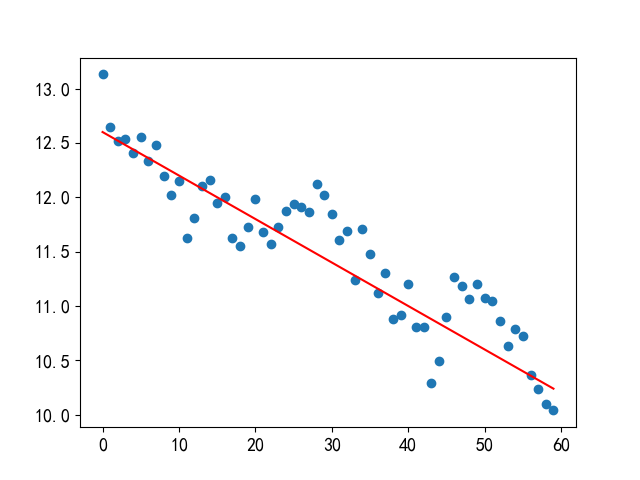

In [5]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

12.6 -0.04
Above
-0.04


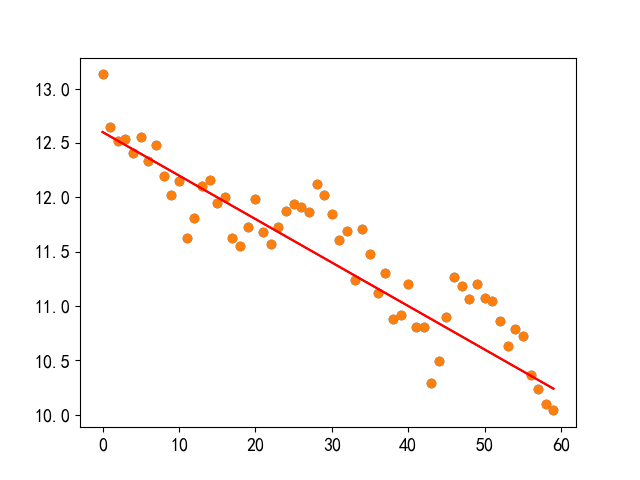

In [6]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, window=10):
    # Calculate the coefficients of the regression line
    if isinstance(df, pd.Series):
        # Y = df.values[-window:]
        # X = df.reset_index().index[-window:]
        Y = df.values
        X = df.reset_index().index
    else:
        if 'close' in df.columns:
            df = df.reset_index()
            # X = df.index[-limit:]
            # Y = df.close[-limit:]
            X = df.index
            Y = df.close
        else:
            # Y = df.values[-limit:]
            # X = df.reset_index().index[-limit:]
            Y = df.values
            X = df.reset_index().index
            
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    # plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

In [7]:
dfc.columns

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount', 'ma5d',
       'ma10d',
       ...
       'top10', 'ma5dcum', 'ra', 'hmax', 'max5', 'lmin', 'min5', 'cmean', 'hv',
       'lv'],
      dtype='object', length=112)

### check_postion_vol_price

In [8]:
from sklearn.linear_model import LinearRegression


def check_postion_vol_price(df):
    # 加载数据
    # df = pd.read_csv("data.csv")

    # 创建输入数据
    X = df[["close", "vol"]].values
    y = df["close"].values

    # 训练回归模型
    reg = LinearRegression().fit(X, y)

    # 计算斜率和截距
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # 计算上轨和下轨
    upper_band = slope * df["close"] + intercept + 2 * df["vol"]
    lower_band = slope * df["close"] + intercept - 2 * df["vol"]

    # 判断价格是否在通道内
    df["Positon"] = np.where(
        df["close"] > upper_band, "Long", np.where(
            df["close"] < lower_band, "Short", "Neutral"))
    return df


dfc = check_postion_vol_price(dfc)
dfc[-1:]

date    code   open   high   low  close         vol       amount  \
59  2023-09-18  601360  10.05  10.19  10.0  10.04  67623041.0  681729549.0   

     ma5d  ma10d  ...  ma5dcum  ra   hmax   max5   lmin   min5  cmean  \
59  10.29  10.59  ...     10.8  10  13.13  11.07  10.08  10.58  10.36   

             hv          lv  Positon  
59  262404060.0  58327377.0  Neutral  

[1 rows x 113 columns]

In [9]:

# dfc=  dfc.rename(columns={'date': 'Date', "open":"Open","high":"High","low": "Low","close":"Close"})
dfc.columns
# dfc[["Date", "Open", "High", "Low", "Close"]][-2:]
dfc.date[:3]
dfc.date = pd.to_datetime(dfc.date)
# dfc.set_index('date')
dfc.date[-1:]

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount', 'ma5d',
       'ma10d',
       ...
       'ma5dcum', 'ra', 'hmax', 'max5', 'lmin', 'min5', 'cmean', 'hv', 'lv',
       'Positon'],
      dtype='object', length=113)

0    2023-06-27
1    2023-06-28
2    2023-06-29
Name: date, dtype: object

59   2023-09-18
Name: date, dtype: datetime64[ns]

### show_ohlc_upper 

xratio:-0.04 


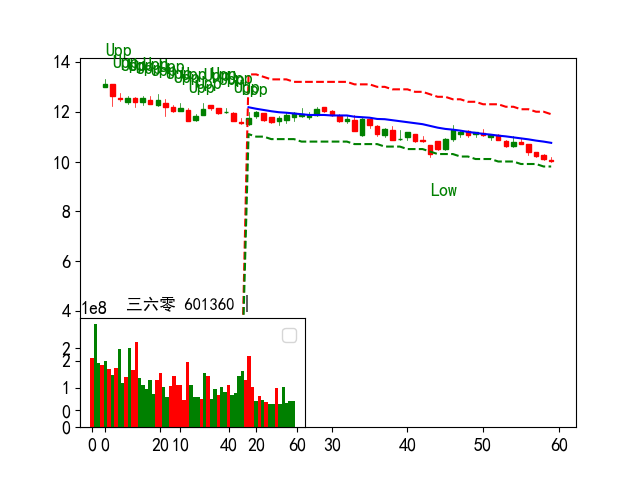

In [10]:

def show_ohlc_upper(df, code=None, allshow=True):
    # 加载数据
    # df = pd.read_csv("data.csv")
    # plt.close()
    # 计算OHLC数据
    # df = df.rename(columns={'date': 'Date', "open": "Open",
    #                "high": "High", "low": "Low", "close": "Close"})
    # df.Date = df.Date.apply(lambda x:str(x).replace('-',''))
    if 'name' not in df.columns and code is not None:
        df['name']= tdd.get_sina_data_code(code)
    if allshow:
        if 'ra_diff' in df.columns:
            print("xratio:%s ra_diff:%s" % (regression_ratio(df),df.ra_diff[-1]))
        else:
            print("xratio:%s " % (regression_ratio(df)))
    # df=df[df.upper > 0]
    df = df.rename(columns={'vol': 'volume'})
    df = df.reset_index()
    # df.date = pd.to_datetime(df.index)
    df.date = df.index
    # print(df.Date)
    # ohlc = df[["Date", "Open", "High", "Low", "Close"]].values
    ohlc = df[["date", "open", "high", "low", "close", 'volume']].values

    # 计算上轨和下轨
    # upper_band = df[df.upper != 0].upper
    # lower_band = df[df.lower != 0].lower
    upper_band = df.upper
    lower_band = df.lower
    
    # print(lower_band,df.lower)
    # print(upper_band,df.upper)

    if 'ma20d' in df.columns:
        ma20d = df[df.ma20d > 0].ma20d
    elif 'ma20' in df.columns:
        ma20d = df[df.ma20 > 0].ma20
    else:
        print('not ma20 ma20d')
    idx = len(df) - len(upper_band)
    idx2 = len(df) - len(lower_band)
    if idx != idx2:
        print(idx, len(df), len(upper_band))
        print(idx2, len(lower_band))

    # 计算当前价格的位置
    position = ['' for i in range(len(df))]
    # print(idx,len(df) ,len(upper_band),position)
    
        # else:
            # position[i] = 'Middle Band'
    # print(position)
    # 绘制OHLC图
    fig, ax = plt.subplots()
    candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')

    # 添加上轨和下轨
    
    for i in range(idx, len(upper_band), 1):
        # print(df["close"][i])
        # print(upper_band[i],df["low"][i])
        # print(i,lower_band[i])
        #error upper_band ==0.0
        if df["close"][i] > upper_band[i]:
            position[i] = 'Upp'
        elif df["low"][i] < lower_band[i]:
            position[i] = 'Low'
            
    plt.plot(upper_band.index, upper_band, 'r--', label='Upper Band')
    plt.plot(lower_band.index, lower_band, 'g--', label='Lower Band')
    
    plt.plot(ma20d.index, ma20d, 'b', label='ma20')

    if 'hat' in df.columns:
        plt.plot(df.hat.index, df.hat, 'b', label='hat')
    # 添加位置
    for i, txt in enumerate(position):
        if txt == 'Low':
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, -30), textcoords='offset points', color='g')
        else:
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, 20), textcoords='offset points', color='g')
    axx = fig.add_subplot(325)
    # axx.plot(df[["volume"]])
    # from matplotlib import transforms
    # pad = 0.25
    # yl = ax.get_ylim()
    # ax.set_ylim(yl[0]-(yl[1]-yl[0])*pad,yl[1])
    # axx = ax.twinx()
    # axx.set_position(transforms.Bbox([[0.125,0.1],[0.9,0.32]]))

    volume = np.asarray(df.volume)
    pos = df['open'] - df['close'] < 0
    neg = df['open'] - df['close'] >= 0
    idx = np.asarray([x for x in range(len(df.date))])
    # print len(dates),len(df),ax.get_xlim(),ax.get_xticks()
    axx.bar(idx[pos], volume[pos], color='red', width=1, align='center')
    axx.bar(idx[neg], volume[neg], color='green', width=1, align='center')

    # position = ['' for i in range(len(df))]
    # position = df.Positon
    # for i, txt in enumerate(position):
    #     plt.annotate(txt, (df["Date"][i], df["Close"][i]), xytext=(0,20), textcoords='offset points')
    # 添加图例
    plt.legend(loc='best')
    # plt.legend(["Now:%s" % df.close[-1], "Hi:%s" % df.high[-1], "Lo:%0.2f" % (asset.iat[-1]), "day:%s" %
    #             len(asset), "fib:%s" % (fib),"MA:%s"%(roll_mean_days)], fontsize=12, loc=0)
    if 'name' in df.columns:
        if 'code' in df.columns:
            plt.title(df.name.values[-1:][0] + " " + df.code[0] + " | ", fontsize=12)
        else:
            plt.title(str(df.name.values[-1:][0]) + " " + " | ", fontsize=12)

    else:
        if 'code' in df.columns:
            plt.title(" | " + df.code[0] + " | ", fontsize=12)
        else:
            if code is None:
                plt.title(" | " + " | ", fontsize=12)
            else:
                plt.title(" | " + code + " | ", fontsize=12)

    # 显示图形
    plt.show()


show_ohlc_upper(dfc,code=dfc.code[0])

In [11]:
'code' in dfc.columns

True

### show_channel_mpl

In [12]:
dfc['position'] = 0


def show_channel_mpl_bug(df, limit=60):
    # Compute the channel
    def compute_channel(df):
        # Compute the high and low of the past n periods
        n = 20
        high = df['high'].rolling(window=n, min_periods=n).max()
        low = df['low'].rolling(window=n, min_periods=n).min()
        df['upper_channel'] = high + (high - low) * 0.5
        df['lower_channel'] = low - (high - low) * 0.5

        # Update the position based on the current price
        df['position'] = np.where(df['close'] > df['upper_channel'] * 0.66, 1,
                                  np.where(df['close'] < df['lower_channel'], -1, 0))
        # print(df['position'])

    df = df.rename(columns={'vol': 'volume'})
    # df = df.reset_index()
    if 'date' in df.columns:
        df.date = pd.to_datetime(df.date)
    else:
        df = df.reset_index()
        df.date = pd.to_datetime(df.date)
    df = df.set_index('date')
    # df.date = df.index
    df = df.loc[:, ["open", "high", "low", "close", 'volume']]
    compute_channel(df)

    # fig, ax = plt.subplots()
    # Plot the ohlc chart
    mpf.plot(df, type='candle', title='OHLC chart with channel and position',
             ylabel='Price', volume=True, mav=(10, 20),
             show_nontrading=False, ylabel_lower='Position')
    # returnfig=True)

    # for i, txt in enumerate(df.position):
    #     # print(i,txt,df.index[i], df["close"][i])
    #     if txt == 0:
    #         plt.annotate("Down", (df.index[i], df["close"][i]), xytext=(
    #             0, -30), textcoords='offset points', color='g')
    #     else:
    #         plt.annotate("UP", (df.index[i], df["close"][i]), xytext=(
    #             0, 20), textcoords='offset points', color='g')

    # axlist[0].set_yticks([-1, 0, 1])
    # axlist[2].xaxis.set_ticks(df['position'])
    # axlist[2].set_xticklabels(df['upper_channel'])
    # yticks=[-1, 0, 1], yticklabels=['Sell', 'Hold', 'Buy'],
    # overlays=[(df['upper_channel'], None), (df['lower_channel'], None)])
# show_channel_mpl(dfc)

## TDX def

In [13]:
global sina_dm
sina_dm = None


def get_sina_data_cname(df, dm=None, index=False, realtime=False):
    # index_status=False
    global sina_dm
    if dm is None:
        if sina_dm is None:
            dm = sina_data.Sina().market('all')
        else:
            dm = sina_dm.copy()

    if 'ticktime' in df.columns:
        time_l = time.mktime(dm.loc[:, 'ticktime'][-1].timetuple())
        dur = round((time.time() - time_l) / 60, 2)
        if dur > 5:
            print("timel > 5,renew dm")
            dm = sina_data.Sina().market('all')
            sina_dm = dm.copy()

    if realtime:
        print("compute percent")
        df.rename(columns={'low': 'llow',
                  'high': 'lhigh', 'open': 'lopen'}, inplace=True)
        if 'nclose' in dm.columns:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:,
                 ['nclose', 'close', 'name', 'open', 'high', 'low', 'llastp',
                  'ticktime']],
                clean=True)
        else:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:, ['close', 'name', 'open', 'high', 'low', 'llastp', 'ticktime']],
                clean=True)
        dd['perc'] = ((dd['close'] - dd['llastp']) / dd['llastp'] *
                      100).map(lambda x: round(x, 2))
        # dd = cct.combine_dataFrame(df, dm['name'])

    else:
        dd = cct.combine_dataFrame(df, dm['name'])
    # cname = sina_data.Sina().get_code_cname(code)
    return dd


def write_code_to_blk(codew, blk='060'):
    block_path = tdd.get_tdx_dir_blocknew() + '%s.blk' % (blk)
    write_blk = 'n'
    write_blk = cct.cct_raw_input("write blk [Y] or [N]:")
    if write_blk == 'y' or write_blk == 'Y':
        hdf5_wri = cct.cct_raw_input(
            "Rewrite code [Y] or append [N](defalut:N):")
        if hdf5_wri == 'y' or hdf5_wri == 'Y':
            append_status = False
        else:
            append_status = True
        if len(codew) > 3:
            cct.write_to_blocknew(block_path, codew, append_status,
                                  doubleFile=False, keep_last=0)
            ("write:%s block_path:%s" % (len(codew), block_path))
        else:
            ("write error:%s block_path:%s" % (len(codew), block_path))
    return True

def get_multiIndex_drop_last_row(df,dropline=1):

    return df.drop(level='date', labels=df.index.get_level_values('date')[-dropline])

def clean_688(df):
    df = df[(~df.index.str.contains("688"))]
    return df

def clean_sina_dm(dd):
    if (cct.get_now_time_int() > 915 and cct.get_now_time_int() < 926):
        dd = dd[dd.close > 0]
    else:
        dd = dd[dd.open > 0]
    return dd

def compute_perd_value(df, market_value=3, col="vol", col_new='volsum'):

    # if market_value == None or market_value < "2":
    #     market_value = 3
    # if market_value > 1 and len(df[ df["%s%sd" % (col, market_value)] > 2])   :
    market_value = str(market_value)
    if market_value > str(1):
        temp = df[
            df.columns[
                (df.columns >= "%s1d" % (col)) &
                (df.columns <= "%s%sd" % (col, market_value))
            ]
        ]

        df['%s%sd' % (col_new, market_value)] = temp.T.sum().apply(
            lambda x: round(x, 1))
    else:
        print("market_value <= 1,No Compute")

    return df


def show_tdx_data(df, codelist=None, market_value='3', col=None):
    col_src = [
        "name", "couts", "date", "perc", "ra_diff","xratio", "idx", "hat", "close",
        "volsum5d", "hmax", "lmin", "perc1d", "ma20", "ma250", "nclose",
        "llow", 'vol1d', 'vol2d', 'vol3d', 'vol4d', 'vol5d', "perc%sd" %
        (market_value),
        "perc5d"]

    if isinstance(df, pd.Series):
        col_name = [co for co in col_src if co in df.index]
        # col_name.insert(1,'date')
    else:
        col_name = [co for co in col_src if co in df.columns]

    # print(col_name)
    # if isinstance(df, pd.DataFrame) and 'name' in df.columns:
    #     columns_ = col_name
    # else:
    #     if isinstance(df, pd.Series) and 'name' in df.index:
    #         columns_ = col_name.insert(1, "date")
    #     else:
    #         columns_ = col_name.remove("name")
    
    if isinstance(col,list):
        col_name.extend(col)
    elif col is not None:
        col_name.insert(4, col)

    if codelist is None:
        if isinstance(df, pd.Series):
            print("Count:1")
            temp = df.loc[col_name]
        else:
            print("Count:%s %s" % (df.shape))
            temp = df.loc[:, col_name]
    else:
        temp = df.loc[[x for x in codelist if x in df.index], col_name]
    return temp


def get_multi_date_duration(df, dt):
    dd = df.reset_index()
    dd = dd[dd.date >= dt]
    # dd['couts'] = dd.groupby(['code'])['code'].transform('count')
    dd = dd.set_index(['code', 'date'])
    return dd


def get_multi_code_count(df, col='code'):
    dd = df.reset_index()
    dd['couts'] = dd.groupby([col])[col].transform('count')
    dd = dd.sort_values(by=['couts', 'date'], ascending=[0, 1])
    print('count dd.couts')
    dd = dd.set_index(['code', 'date'])
    return dd


def multindex_iloc(df, index):
    label = df.index.levels[0][index]
    return df.iloc[df.index.get_loc(label)]


def get_groupby_mean_median_close(dfs):

    groupd = dfs.groupby(level=[0])

    df = groupd['close'].agg(['median', 'mean'])
    df['close'] = groupd.tail(1).reset_index().set_index(['code'])['close']
    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # dfs = dfs.fillna(0)
    # idx = pd.IndexSlice
    # mask = ( (dfs['mean'] > dfs['median'])
    #         & (dfs['close'] > dfs['mean'])
    #         )
    # df=dfs.loc[idx[mask, :]]

    df = df[(df['mean'] > df['median']) & (df['close'] > df['mean'])]

    # dt_low = None
    # if dl == 1:
    #     dfs = groupd.tail(1)
    #     print("dfs tail1")
    # else:
    #     dl = 30
    #     dindex = tdd.get_tdx_Exp_day_to_df(
    #         '999999', dl=dl).sort_index(ascending=False)
    #     dt = tdd.get_duration_price_date('999999', df=dindex)
    #     dt = dindex[dindex.index >= dt].index.values
    #     dt_low = dt[-1]
    #     dtlen = len(dt) if len(dt) >0 else 1
    #     dfs = groupd.tail(dtlen)
    #     print("dfs tail:%s dt:%s"%(dtlen,dt))
    #     dfs = get_multi_date_duration(dfs,dt[-1])
    return df


def compute_df_Col_lastday(dfs, col='close', colre='perc', days=3, plus=True):
    for da in range(int(days)):
        da += 1
        if plus:
            dfs['%s%sd' % (colre, da)] = round(
                (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
        else:
            if da == 1:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
            else:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col].shift(da - 1) - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
    return dfs

In [14]:
def get_roll_mean_all(
        single=True, tdx=False, app=True, duration=100, ma_250_l=1.02,
        ma_250_h=1.11, resample='d'):
    time_s = time.time()
    if not app and cct.get_file_size(block_path) > 100 and cct.creation_date_duration(block_path) == 0:
        print("It's Today Update")
        return True
    code_list = sina_data.Sina().market('all').index.tolist()
    code_list.extend(['999999', '399001', '399006'])
    print("all code:", len(code_list))
    if duration < 300:
        h5_fname = 'tdx_all_df' + '_' + str(300)
        h5_table = 'all' + '_' + str(300)
    else:
        h5_fname = 'tdx_all_df' + '_' + str(900)
        h5_table = 'all' + '_' + str(900)
    # df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start='20150501', end=None, freq=None, col=None, index='date')
    df = tdd.search_Tdx_multi_data_duration(
        h5_fname, h5_table, df=None, code_l=code_list, start=None, end=None,
        freq=None, col=None, index='date')
    # df = tdd.search_Tdx_multi_data_duration(h5_fname, h5_table, df=None,code_l=code_list, start=None, end=None, freq=None, col=None, index='date',tail=1)

    code_uniquelist = df.index.get_level_values('code').unique()

    code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]
    print(round(time.time() - time_s, 2), df.index.get_level_values(
        'code').unique().shape, code_select, df.loc[code_select].shape)
    # df.groupby(level=[0]),df.index.get_level_values(0)
    # len(df.index.get_level_values('code').unique())
    # df = df[~df.index.duplicated(keep='first')]

    # multiIndex_func = {'close': 'mean', 'low': 'min', 'high': 'max', 'volume': 'sum', 'open': 'first'}
    # cct.using_Grouper(df, freq='W', col={'close': 'last'})
    # *** TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'
    # roll_dl = duration
    if resample != 'd':

        print("resample:%s"%(resample.upper()))
        df = df.groupby(level=0).resample(resample, level=1).last()
        df = df.dropna()
        
    ''' 
    if resample != 'd':
        print("resample:%s" % (resample.upper()))
        # ohlc_dict = {'volume': 'sum','high': 'max','low': 'min','close': 'last'}
        # {'low': 'min', 'close':'mean'}
        # df = df.groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        df = df.loc[:, ['close']].groupby(level=0).resample(
            resample, level=1).agg({'close': 'last'}).dropna()

        df = df.dropna()
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1, how={'low': 'min', 'close':'mean'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.Grouper(freq=resample)).transform(np.cumsum).resample(resample, how='ohlc')

        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.TimeGrouper(resample)).transform(np.cumsum).resample(resample, how='ohlc')
        # r1 = len(df.loc['000001'])
        # r2 = len(df.loc['999999'])
        # roll_dl = r1 if r1 < r2 else r2

        # df['upper'] = map(lambda x: round((1 + 11.0 / 100) * x, 1), df.ma10d)
        # df['lower'] = map(lambda x: round((1 - 9.0 / 100) * x, 1), df.ma10d)
        # df['ene'] = map(lambda x, y: round((x + y) / 2, 1), df.upper, df.lower)
        # dfs['amount%d'%cumdays] = groupd['amount'].apply(pd.rolling_mean, cumdays)
    # df.ix[df.index.levels[0]]
    # df.ix[df.index[len(df.index)-1][0]] #last row
    # dfs = tdd.search_Tdx_multi_data_duration(df=dfs,code_l=code_list, start='20170918', end='20170918', freq=None, col=None, index='date')

    # print dfs[:1],len(dfs)
    # groupd.agg({'low': 'min'})
    #  idx mask filter 
    # h5a.write_hdf_db('all300', df, table='roll200', index=False,baseCount=500, append=False, MultiIndex=MultiIndex)
    '''

    df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code', 'date'])
    print("use time:%s" % (round(time.time() - time_s, 2)))
    return df

# 读取数据 TDX Days

## resample = 'w'

In [15]:
resample = 'W-FRI'
# resample = 'D'

df = get_roll_mean_all(
    single=False, tdx=True, app=True, duration=250, ma_250_l=1.02,
    ma_250_h=1.2, resample=resample)


# df= df.groupby(level=[0]).tail(1).reset_index().set_index('code')
# df_cname = tdd.get_sina_datadf_cnamedf(df.index.tolist(), df)
# df = df.reset_index().set_index(['code', 'date'])

all code: 4974
7.81 (4962,) 000429 (424, 6)
resample:W-FRI
use time:23.66


In [16]:
# df.loc['399001'][-1:]
df.loc['000002'][-1:]
# df.groupby(level=[0]).tail(30).groupby(level=[0]).tail(2)
# df.groupby(level=[0]).tail(30).groupby(level=[0]).head(1)

open   high    low  close         vol        amount
date                                                           
2023-09-22  13.4  13.43  13.27  13.31  43185544.0  5.753974e+08

### Test InStock

In [17]:
df.loc['301083']

open   high    low  close         vol        amount
date                                                            
2021-12-17  19.04  19.07  18.12  18.22   4046124.0  7.507724e+07
2021-12-24  17.49  17.50  16.59  16.60   3024670.0  5.118218e+07
2021-12-31  17.22  17.44  17.14  17.16   1610690.0  2.786333e+07
2022-01-07  17.41  17.54  16.85  16.95   1721200.0  2.961089e+07
2022-01-14  17.91  18.23  17.63  18.18   3364032.0  6.051730e+07
...           ...    ...    ...    ...         ...           ...
2023-08-25  17.70  17.71  15.60  15.83  10811509.0  1.751286e+08
2023-09-01  18.89  19.44  18.88  19.00   7846685.0  1.496490e+08
2023-09-08  18.21  18.35  17.91  17.95   3350200.0  6.060757e+07
2023-09-15  17.19  17.44  16.91  16.95   2379795.0  4.056793e+07
2023-09-22  17.00  17.71  16.80  17.49   3866768.0  6.732102e+07

[90 rows x 6 columns]

## ra_diff

In [18]:
df = df.groupby(level=[0]).tail(30).groupby(level=[0]).apply(ra_diff)


In [19]:
# df.loc['999999'][-3:]
# df.loc['301073'].ra_diff[-3:]
df.loc['300459'].shape

(30, 7)

## X df_regression_ratio outdate
    df_idx_detect

In [20]:
# df_reg_ratio = df.groupby(level=[0])['close'].apply(regression_ratio)
# df_idx_detect = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
# show_ohlc_upper()
# df[:10]

In [21]:
# df_idx_detect.shape, df_idx_detect.loc['000002']
# df.loc['000002'][-2:],df_reg_ratio.loc['000002']
# df.loc['688798'][-3:]

In [22]:
# df.loc['000002'][-10:]

## sina_dm

In [23]:
sina_dm = sina_data.Sina().market('all')
lastday = cct.last_tddate()
lastday,sina_dm.name[:1]
sina_dm = clean_sina_dm(sina_dm)

('2023-09-18',
 code
 600069    退市银鸽
 Name: name, dtype: object)

In [24]:
cct.get_time_to_date(time.time(), format='%Y-%D %H:%M:%S')

# abc=dm.loc[:,'ticktime'][-1]
sina_dm.ticktime[-2:]
# dm.ticktime[:1]
# sina_dm.loc[:, 'ticktime'][-1]
# time.strptime(abc,format='%Y-%m-%d %H:%M:%S')
# (time.mktime(abc.timetuple()))
(time.time() - time.mktime(sina_dm.loc[:, 'ticktime'][-1].timetuple())) / 60

'2023-09/19/23 16:01:39'

code
600133   2023-09-19 15:00:01
002876   2023-09-19 15:00:00
Name: ticktime, dtype: datetime64[ns]

61.660011970996855

### Combine ratio and idx

if 'date' in df.columns:
    print('error duplicated date col')
    if isinstance(df,pd.MultiIndex):
        df.drop('date', axis=1, inplace=True)
else:
    df = df.reset_index().set_index('code')
    df['idx'] = df_idx_detect
    df['xratio'] = df_reg_ratio
    df['name'] = sina_dm.name
    df = df.reset_index().set_index(['code', 'date'])

## 读取实时成交量数据

In [25]:
def apply_col_toint(df, col=None):
    if col is None:
        co2int = ['boll', 'op', 'ratio', 'fib', 'fibl', 'df2']
    # co2int.extend([co for co in df.columns.tolist()
    #                if co.startswith('perc') and co.endswith('d')])
        co2int.extend(['top10', 'topR'])
    else:
        co2int = col
    co2int = [inx for inx in co2int if inx in df.columns]

    for co in co2int:
        df[co] = df[co].astype(int)

    return df

def readHdf5(fpath, root=None):
    store = pd.HDFStore(fpath, "r")
    print(store.keys())
    if root is None:
        root = store.keys()[0].replace("/", "")
    df = store[root]
    df = apply_col_toint(df)
    store.close()
    return df

In [26]:
# tdx_path = "G:\\tdx_last_df.h5"
# from JohnsonUtil import commonTips as cct
sina_MultiD_path = "G:\\sina_MultiIndex_data.h5"
h5 = readHdf5(sina_MultiD_path)
print(sina_MultiD_path)
h5.shape
# h5[:1]
code_muti = '600519'
# h5.loc[code_muti][:2]

freq = 'D'
startime = '09:25:00'
endtime = '15:01:00'

time_ratio = cct.get_work_time_ratio()
time_ratio
run_col = ['close', 'volume']
mdf = cct.get_limit_multiIndex_freq(
    h5, freq=freq.upper(),
    col=run_col, start=startime, end=endtime, code=None)
allvol = mdf.volume.sum()
allvol / 1000 / 1000 / 1000
mdf['amount']=mdf['volume'].apply(lambda x: round(x /100,2)) 
mdf['vol']=(mdf.volume / mdf.close).map(lambda x: round(x/100, 2))
mdf['volume'] = mdf.volume.apply(
    lambda x: round(x / allvol * 100 / time_ratio, 2))
mdf=mdf.reset_index().set_index('code')

['/all_10']
G:\sina_MultiIndex_data.h5


(2115467, 6)

1.0

14971.245908061

In [27]:
# h5.index.get_level_values('code')[0]
# help(h5.index.get_level_values)
str(h5.index.get_level_values(1)[-1])[:10]

'2023-09-19'

In [28]:
if len(mdf) > 0:
    mdf.loc['000002']
else:
    print("mdf is None")

ticktime    2023-09-20 00:00:00
close                 13.298852
volume                     0.06
amount              85718391.09
vol                  6445547.94
Name: 000002, dtype: object

###  实时成交量个股Top

In [29]:
nowdf = mdf.sort_values(by=['volume'], ascending=[0])
# nowdf.shape, df.shape, code_idx.shape
# top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
top20_nd = nowdf.reset_index().loc[:, ['code', 'volume']][:20]
top20_nd=get_sina_data_cname(top20_nd)

In [30]:
nowdf.shape,top20_nd

((4903, 5),
         volume  name
 code                
 000536    1.21  华映科技
 002269    0.70  美邦服饰
 002547    0.68  春兴精工
 601099    0.66   太平洋
 601288    0.60  农业银行
 600256    0.50  广汇能源
 000656    0.50  金科股份
 000851    0.48  高鸿股份
 002310    0.46  东方园林
 600839    0.45  四川长虹
 600221    0.44  海航控股
 000010    0.42  美丽生态
 000766    0.41  通化金马
 002654    0.40  万润科技
 300255    0.39  常山药业
 600408    0.38  安泰集团
 600157    0.36  永泰能源
 600155    0.35  华创云信
 600777    0.35  新潮能源
 600919    0.34  江苏银行)

### 合并实时成交量及SinaDM

In [31]:
# mdf[:1]
sinadm = cct.combine_dataFrame(sina_dm, mdf[['vol','amount']])
sinadm[:1]

name  open  llastp   now  trade  high   low   buy  sell    volume  \
code                                                                        
002448  中原内配  7.19    7.26  7.08    0.0  7.37  7.01  7.07  7.08  37366635   

        ...  close      nvol         timel  lastbuy  nlow  nhigh  nclose  \
code    ...                                                                
002448  ...   7.08  37366635  1.695083e+09     7.08  7.01   7.37    7.11   

        nstd          vol        amount  
code                                     
002448  -2.0  15829958.86  1.125940e+08  

[1 rows x 44 columns]

## check HDF LastDate

In [32]:
df_tail1 = df.groupby(level=[0]).tail(1)
# df_tail1.index

df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()].shape

(0, 7)

(4962, 7)

In [33]:
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()][:1]

open       high       low      close          vol  \
code   date                                                                 
999999 2023-09-22  3110.4404  3128.7009  3098.496  3125.9319  259444257.0   

                         amount  ra_diff  
code   date                               
999999 2023-09-22  2.996447e+11     1.02

In [34]:
# df.info()
# code_t = '600519'
# print(dfNow.loc[code_t][-3:])
# df.loc['000001'][-1:]
# dfbak = df.copy()
# df[(df.idx > df.idx.shift(1)) & (df.xratio > df.xratio.shift(1))].shape


## reindex sort date

In [35]:
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])

## 初始化参数

In [36]:
app = True
tdx = True
duration = 300
ma_250_l = 1.02
ma_250_h = 1.2

if resample.upper() == 'D' or resample.lower() == 'd':
    if duration < 300:
        rollma = ['10', '5', '20']
    else:
        rollma = ['10', '5', '20', '250']

elif resample.upper() == 'W' or resample.lower() == 'w':
    rollma = ['5', '10']
else:
    rollma = ['5', '10']
        

def init_MulitiData_Roll(df,resample='d',duration=300):
    time_s = time.time()
    dfs = df.copy()
    # dfs = df.loc['600519']
    # groupd = dfs.groupby(level=[0])
    # groupd.['close']
    # rollma = ['5','10','60','100','200']
    # rollma = ['5','10','250']
    # df.index.get_level_values('code')[0]
    if resample.upper() == 'D' or resample.lower() == 'd':
        if duration < 300:
            rollma = ['10', '5', '20']
        else:
            rollma = ['10', '5', '20', '250']

    elif resample.upper() == 'W' or resample.lower() == 'w':
        rollma = ['5', '10','20']
    else:
        rollma = ['5', '10','20']

    # rollma.extend([str(duration)])

    # import ipdb;ipdb.set_trace()
    # df.loc['300130'][:2]

    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # BOLL:MA(CV,N), COLORMAGENTA;
    # UPPER:BOLL+P*STD(CV,N), COLORYELLOW;
    # LOWER:BOLL-P*STD(CV,N), COLORYELLOW;
    # df['BollUpper'] = df.close.shift(10).mean()+2*df.close.shift(10).std()
    # df['BollDown'] = df.close.shift(10).mean()-2*df.close.shift(10).std()
    for da in rollma:
        cumdays = int(da)
        dfs['ma%d' % cumdays] = round(dfs['close'].rolling(cumdays).mean(), 2)

        # dfs['upper'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 + 11.0 / 100) * x, 1))
        # dfs['lower'] = dfs['ma%d' % cumdays].apply(
        #     lambda x: round((1 - 9.0 / 100) * x, 1))
        # dfs['boll'] = list(map(lambda x, y: round(
        #     (x + y) / 2, 1), dfs['upper'], dfs['lower']))
    if duration > 100:
        dfs['upper'] = round(
            dfs['close'].rolling(20).mean() + 2 *
            dfs['close'].rolling(20).std(),
            2)
        dfs['lower'] = round(
            dfs['close'].rolling(20).mean() - 2 *
            dfs['close'].rolling(20).std(),
            2)

        dfs['boll'] = round(dfs['close'].rolling(20).mean(), 2)

        dfs['hmax'] = round(dfs['high'].rolling(20).max(), 2)
        dfs['lmin'] = round(dfs['low'].rolling(20).min(), 2)

        dfs['hat'] = dfs['upper'] - dfs['lower']

        # dfs['hmax'] = round(dfs['close'].cummax(), 2)


    dfs = compute_df_Col_lastday(dfs, col='close', colre='perc', days=5)
    dfs = compute_df_Col_lastday(dfs, col='vol', colre='vol', days=5, plus=False)
    dfs = compute_perd_value(dfs, market_value=5, col='vol', col_new='volsum')

    return dfs
# dfs['perc1d'] = round(
#     (dfs['close'] - dfs['close'].shift(1)) / dfs['close'].shift(1) * 100, 2)
# dfs['perc3d'] = round(
#     (dfs['close'] - dfs['close'].shift(3)) / dfs['close'].shift(3) * 100, 2)
# dfs['perc5d'] = round(
#     (dfs['close'] - dfs['close'].shift(5)) / dfs['close'].shift(3) * 100, 2)

In [37]:
dfs=init_MulitiData_Roll(df,resample=resample)

### DFS MutiIndex Test 0507

In [38]:
# dfs.loc['000002'][-5:].upper
dfs.loc['603357'][-5:][['close','upper','low','boll']]
dftemp = dfs.loc['603357']
dftemp[dftemp.close > dftemp.upper]

close  upper   low   boll
date                                 
2023-08-25   9.48  15.12  9.45  11.72
2023-09-01   9.62  15.16  9.52  11.63
2023-09-08   9.65  15.19  9.60  11.55
2023-09-15   9.43  15.20  9.41  11.45
2023-09-22   9.51  14.96  9.35  11.25

Empty DataFrame
Columns: [open, high, low, close, vol, amount, ra_diff, ma5, ma10, ma20, upper, lower, boll, hmax, lmin, hat, perc1d, perc2d, perc3d, perc4d, perc5d, vol1d, vol2d, vol3d, vol4d, vol5d, volsum5d]
Index: []

[0 rows x 27 columns]

In [39]:
# dfs.loc['688027']
dfs['ma51d'] = round(dfs['close'].rolling(5).mean(), 2)
show_tdx_data(dfs.loc['600519'][-2:],col=['ma51d','ra_diff'])
# show_tdx_data(dfs.loc['600519'])

Count:2 28


ra_diff     hat    close  volsum5d     hmax     lmin  perc1d  \
date                                                                       
2023-09-15     1.07  290.46  1781.99      67.4  1906.52  1636.11   -2.01   
2023-09-22     1.10  295.34  1829.20     118.4  1906.52  1636.11    2.65   

               ma20   vol1d   vol2d  vol3d  vol4d  vol5d  perc3d  perc5d  \
date                                                                       
2023-09-15  1766.19  132.82   -7.10 -25.52   3.68 -36.45   -2.40   -2.84   
2023-09-22  1770.15   14.52  132.82  -7.10 -25.52   3.68   -1.18    1.48   

              ma51d  ra_diff  
date                          
2023-09-15  1815.98     1.07  
2023-09-22  1821.30     1.10

### Append Now SinaTo MultiIndex dfNow

In [40]:
cct.get_today()
def get_Append_Sina_To_MultiTDX(df,sina_dm):
    sina_today=sina_dm.copy()
    if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
        sina_today['date']=pd.to_datetime(cct.get_today())
        print('concat1 init:sina_today:%s'%(sina_today.index[0]))
        # df_reg_ratio2 = df.groupby(level=[0])['close'].apply(regression_ratio)
        # df_idx_detect2 = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
        # sina_today['idx'] = df_idx_detect2
        # sina_today['xratio'] = df_reg_ratio2
        # sina_today=sina_today.loc[:,['open','high','low','close','date','idx',y'xratio']].reset_index().set_index(['code', 'date'])
        if 'vol' in sina_today.columns:
            sina_today=sina_today.loc[:,['open','high','low','close','vol','amount','name','date']].reset_index().set_index(['code', 'date'])
        else:
            sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])

    if sina_today.index[0] not in df.index:
        # df.index=df.index.append(sina_dm.index)
        print('concat1:sina_today:%s %s'%(sina_today.index[0]))
        df = pd.concat([df, sina_today])


#         sina_today=sina_dm.copy()
#         #drop line and append idx
#         if not isinstance(sina_today,pd.MultiIndex) and  'date' not  in sina_today.columns:
#             sina_today['date']=pd.to_datetime(cct.get_today())
#             print('concat2 init:sina_today:%s'%(sina_today.index[0]))

#             sina_today['idx'] = df_idx_detect2
#             sina_today['xratio'] = df_reg_ratio2
#             sina_today=sina_today.loc[:,['open','high','low','close','date','name','idx','xratio']].reset_index().set_index(['code', 'date'])
#             # sina_today=sina_today.loc[:,['open','high','low','close','date']].reset_index().set_index(['code', 'date'])   


#         df = get_multiIndex_drop_last_row(df,dropline=1)

        if sina_today.index[0] not in df.index:
            # df.index=df.index.append(sina_dm.index)
            print('concat2:sina_today:%s %s'%(sina_today.index[0]))
            df = pd.concat([df, sina_today])
        df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
    return df

# dfNow=get_Append_Sina_To_MultiTDX(df.groupby(level=[0]).tail(30),sina_dm)


if resample.upper() == 'D':
    dfNow=get_Append_Sina_To_MultiTDX(dfs.groupby(level=[0]).tail(30),sinadm)
    dfNow=init_MulitiData_Roll(dfNow,resample=resample,duration=20)
else:
    dfNow = dfs.groupby(level=[0]).tail(30).copy()
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])
# df.loc[code_df][-2:]


'2023-09-19'

In [41]:
# dfNow.loc['000002']

### Xratio and tail 30 MultiIndex 

In [42]:
# dfNow['xratio'] = dfNow['close'].rolling(30).apply(regression_ratio)
df_xratio = dfNow.groupby(level=[0])['close'].rolling(24).apply(regression_ratio)
df_xratio.index =df_xratio.to_frame().index.droplevel(1)
dfNow['xratio'] = df_xratio

In [43]:
# dfNow['idx'] = dfNow['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx = dfNow.groupby(level=[0])['close'].rolling(25).apply(detect_bull_bear_apply)
df_idx.index =df_idx.to_frame().index.droplevel(1)
dfNow['idx'] = df_idx

### dfNow Top

date
2023-09-15    7.91
2023-09-22    7.42
Name: upper, dtype: float64

xratio:-0.09 ra_diff:1.0


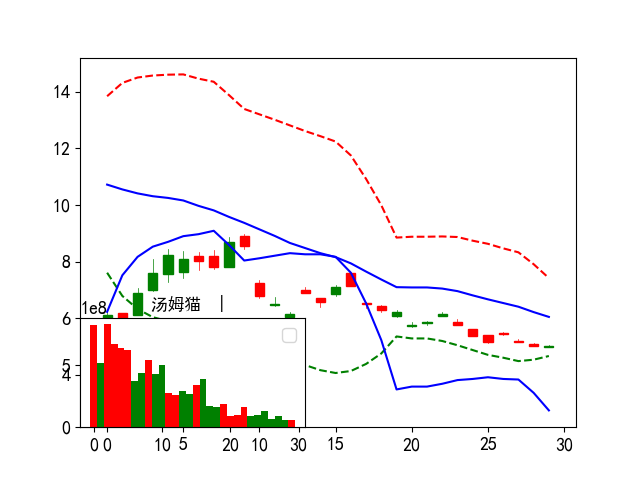

In [44]:
dfNow.loc['300459'][-2:].upper
show_ohlc_upper(dfNow.loc['300459'][-30:],code='300459')

000536 1.92
xratio:0.02 ra_diff:1.92


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


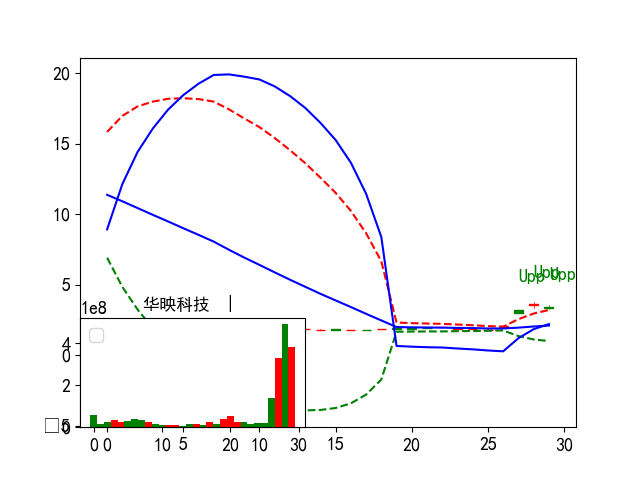

002269 1.32
xratio:0.0 ra_diff:1.32


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


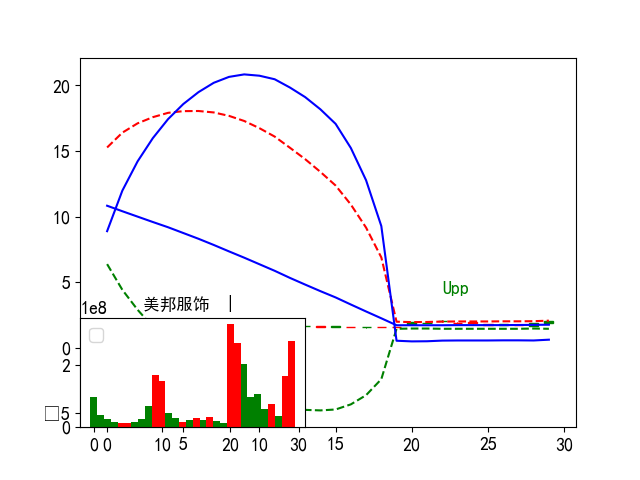

002547 1.43
xratio:-0.01 ra_diff:1.43


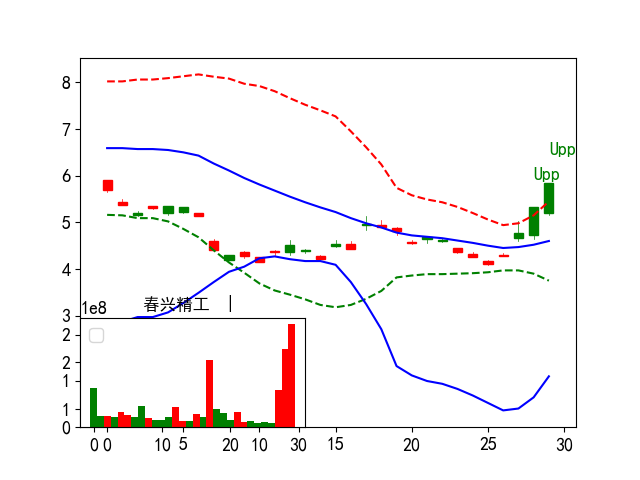

601099 1.51
xratio:0.06 ra_diff:1.51


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


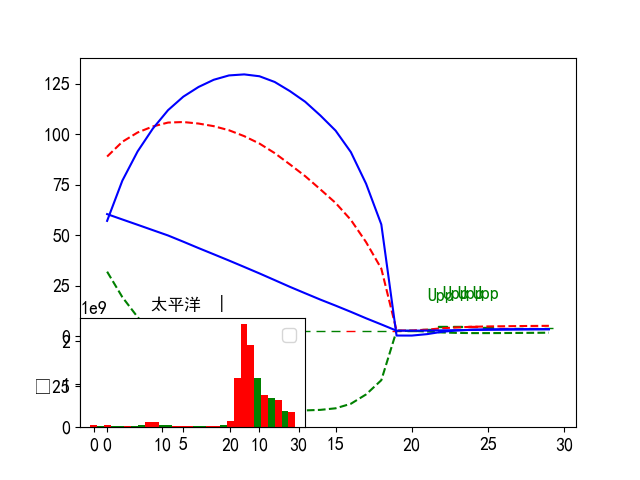

601288 1.17
xratio:0.01 ra_diff:1.17


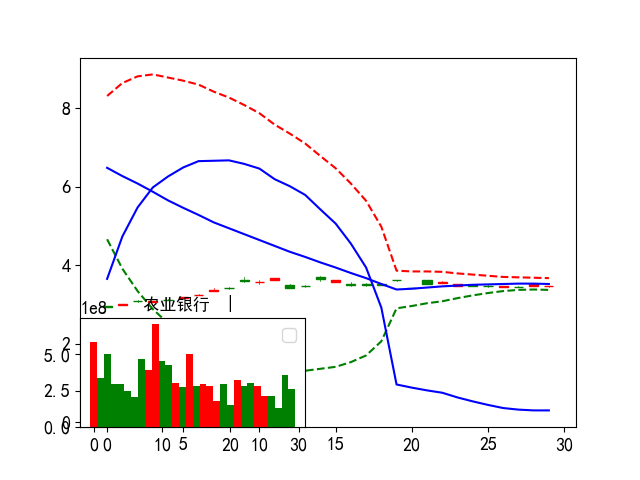

600256 1.12
xratio:-0.12 ra_diff:1.12


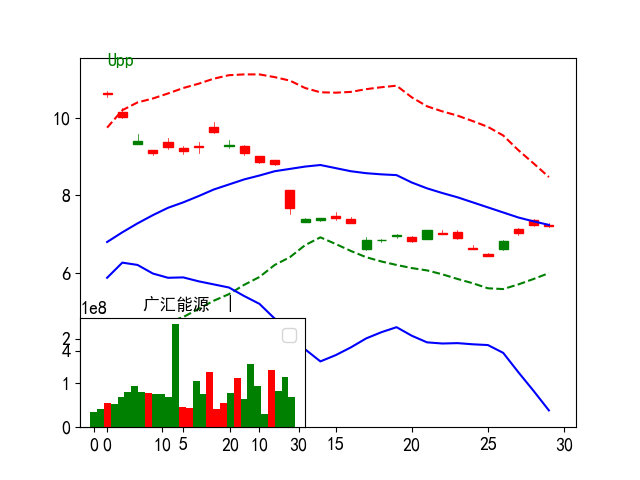

000656 2.11
xratio:0.02 ra_diff:2.11


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


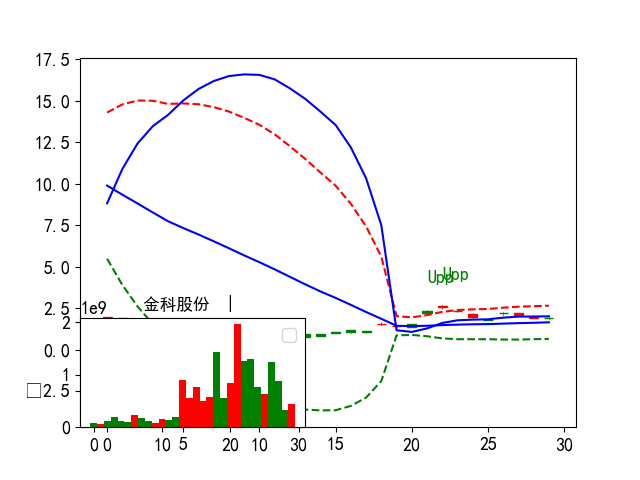

000851 1.27
xratio:-0.03 ra_diff:1.27


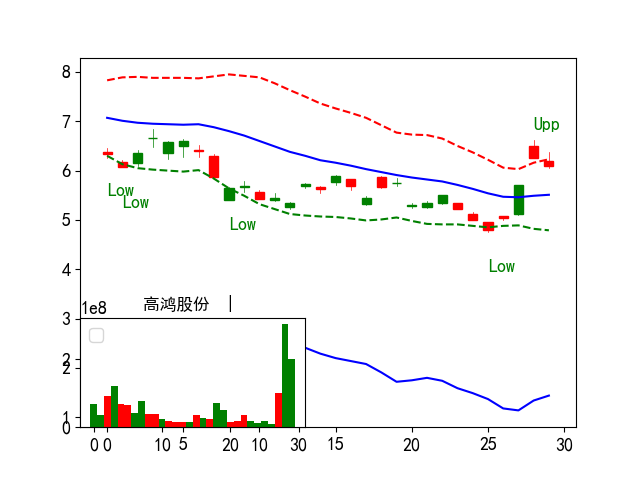

002310 1.62
xratio:0.02 ra_diff:1.62


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


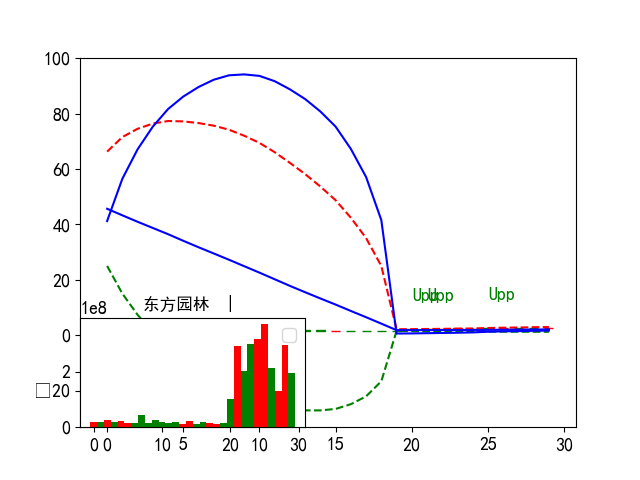

600839 1.52
xratio:0.02 ra_diff:1.52


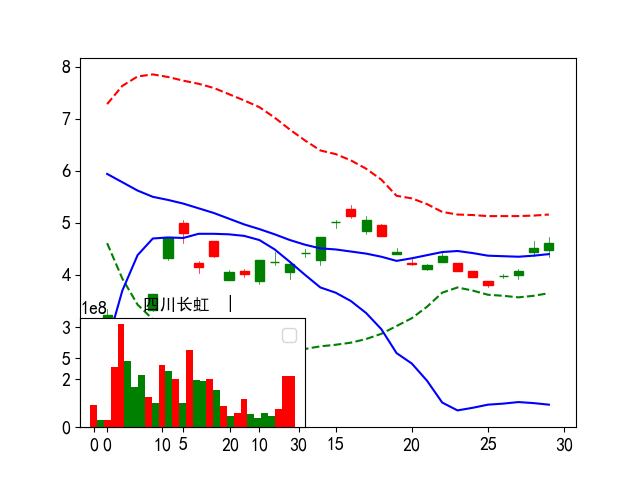

In [45]:
for co in top20_nd.index[:10]:
    print(co,dfNow.loc[co].ra_diff[-1])
    # show_ohlc_upper(dfs.loc[co][-30:],co)
    show_ohlc_upper(dfNow.loc[co][-30:],co)

In [46]:
code_df = '600519'
dfNow_t2 = dfNow.groupby(level=[0]).tail(2)
# dfNow_f = dfNow_t2[ (dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) ]
idx = pd.IndexSlice
mask_df =  ((dfNow_t2.idx > dfNow_t2.idx.shift(1)) & (dfNow_t2.xratio > dfNow_t2.xratio.shift(1)) )

dfNow_t2 = dfNow_t2.loc[idx[mask_df, :]]

group250 = dfNow_t2.groupby(level=[0])
dfNow_f = group250.tail(1).reset_index().set_index('code')
mask_df = (dfNow_f.date >= cct.get_today())
dfNow_f = dfNow_f.loc[idx[mask_df, :]]
dfNow_f[:2]

date       open       high       low      close          vol  \
code                                                                        
999999 2023-09-22  3110.4404  3128.7009  3098.496  3125.9319  259444257.0   
688800 2023-09-22    38.9200    40.7600    38.540    39.7700    1490745.0   

              amount  ra_diff      ma5     ma10  ...  perc5d  vol1d  vol2d  \
code                                             ...                         
999999  2.996447e+11     1.02  3110.99  3160.79  ...   -0.19 -11.16  28.01   
688800  5.943550e+07     1.02    40.39    44.54  ...  -11.50  23.27   0.86   

        vol3d  vol4d  vol5d  volsum5d    ma51d  xratio    idx  
code                                                           
999999 -21.96   5.18  -5.60      -5.5  3110.99   -9.09 -41.81  
688800 -23.00  13.66   4.33      19.1    40.39   -1.60 -11.18  

[2 rows x 31 columns]

In [47]:
# dfNow_f.shape,dfNow_f[:3],dfNow_t2.loc['600812'],df.loc['600812'][-2:]
# dfNow_f[dfNow_f.date >= cct.get_today()]
# dfNow_f.loc['000006']
# dfNow_t2.loc['000006']
# (dfNow_t2.loc[code_df].idx > dfNow_t2.loc[code_df].idx.shift(1)) 
# (dfNow_t2.loc[code_df].xratio > dfNow_t2.loc[code_df].xratio.shift(1))
# dfNow_f.loc[code_df],dfNow.loc[code_df]

### pandas multiinde drop last row

In [48]:
df.loc['000002'][-2:]

open   high    low  close         vol        amount  ra_diff
date                                                                     
2023-09-15  13.59  13.62  13.41  13.42  38951414.0  5.255363e+08     1.01
2023-09-22  13.40  13.43  13.27  13.31  43185544.0  5.753974e+08     1.00

In [49]:
dfNow.loc['000002'][-2:]

open   high    low  close         vol        amount  ra_diff  \
date                                                                        
2023-09-15  13.59  13.62  13.41  13.42  38951414.0  5.255363e+08     1.01   
2023-09-22  13.40  13.43  13.27  13.31  43185544.0  5.753974e+08     1.00   

              ma5   ma10   ma20  ...  perc5d  vol1d  vol2d  vol3d  vol4d  \
date                             ...                                       
2023-09-15  13.83  14.20  14.35  ...   -8.08  -7.63 -59.85  17.97  61.87   
2023-09-22  13.63  14.15  14.24  ...   -6.99  10.87  -7.63 -59.85  17.97   

            vol5d  volsum5d  ma51d  xratio   idx  
date                                              
2023-09-15 -31.50     -19.1  13.83   -0.07 -0.36  
2023-09-22  61.87      23.2  13.63   -0.07 -0.67  

[2 rows x 30 columns]

# 基础处理

In [50]:
# show_tdx_data(dfs.loc['600519'][-2:])
dfs = dfNow.fillna(0)
groupd = dfs.groupby(level=[0])
single = False
dt_low = None
df_idx = None
if single:
    dfs_dtlen = groupd.tail(1)
    print("dfs tail1")
else:
    single = True
    dl = 30
    dindex = tdd.get_tdx_Exp_day_to_df(
        '999999', dl=dl, resample=resample).sort_index(ascending=False)
    dt = tdd.get_duration_price_date('999999', df=dindex)

    dt = dindex[dindex.index >= dt].index.values
    dt_low = dt[-1]
    print('dt_low:%s %s' % (dt_low,dt[0]))
    dtlen = len(dt) if len(dt) > 0 else 1
    dfs_dtlen = groupd.tail(dtlen)
    # import ipdb;ipdb.set_trace()
    dfs_dtlen[-2:]
    df_idx = get_groupby_mean_median_close(dfs_dtlen)

    # print(("dfs tail:%s dt:%s" % (dtlen, dt)))
    dfs_dtlen = get_multi_date_duration(dfs_dtlen, dt[-1])

# groupd2 = dfs.groupby(level=[0])
# dfs['ma%d'%cumdays] = groupd['close'].apply(pd.rolling_mean, cumdays)

# dfs.reset_index().groupby(['code'])['date'].transform('count')
# single = True

print("Low:%s" % (dt[-1]))
# dfs_dtlen.loc['999999'].reset_index().date
lastday_week = dfs_dtlen.loc['999999'].reset_index().date[0]
lastday_week
# dfs_dtlen[('ma%s') % (rollma[-1])][-2:]
# print(df_idx)

dt_low:2023-08-25 2023-09-18


open   high    low  close         vol        amount  \
code   date                                                               
000001 2023-09-15  11.35  11.40  11.20  11.22  89047613.0  1.005529e+09   
       2023-09-22  11.22  11.24  11.14  11.23  50132501.0  5.614498e+08   

                   ra_diff    ma5   ma10   ma20  ...  perc5d  vol1d  vol2d  \
code   date                                      ...                         
000001 2023-09-15      1.0  11.32  11.58  11.76  ...   -5.63  85.89 -57.93   
       2023-09-22      1.0  11.25  11.56  11.68  ...   -2.85 -43.70  85.89   

                   vol3d  vol4d  vol5d  volsum5d  ma51d  xratio   idx  
code   date                                                            
000001 2023-09-15  39.98  23.29 -30.07      61.2  11.32   -0.06 -0.24  
       2023-09-22 -57.93  39.98  23.29      47.5  11.25   -0.06 -0.11  

[2 rows x 30 columns]

Low:2023-08-25


Timestamp('2023-08-25 00:00:00')

In [51]:
time_s = time.time()
# rollma

def get_mask_df(dfs):
    dfs = dfs.fillna(0)
    idx = pd.IndexSlice
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[1])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) &  (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])

    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))
    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]*ma_250_l)
    #         & (dfs[('close')] < dfs[('ma%s')%(rollma[-1])]*ma_250_h)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))

    # & (dfs['mean'] > dfs['median'])
    # & (dfs['close'] > dfs['mean'])

    if len(rollma) > 1:

        mask = ((dfs[('ma%s') % (rollma[0])] > 0) & (dfs[('ma%s') % (rollma[-1])] > 0) &
                (dfs[('ma%s') % (rollma[0])] > dfs[('ma%s') % (rollma[-1])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[0])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[-1])]*ma_250_h) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']))
                )
    else:
        mask = ((dfs[('ma%s') % (rollma[0])] > 0) &
                (dfs[('close')] > dfs[('ma%s')%(rollma[0])]) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']) )
                )

    return dfs.loc[idx[mask, :]]

# mask = ((dfs[('close')] > dfs[('ma%s')%(rollma[-1])]))


df_mask = get_mask_df(dfs_dtlen)
print(df_mask.shape)
df_mask = get_multi_code_count(df_mask)
print((df_mask.couts[:5], df_mask.shape))

# import ipdb;ipdb.set_trace()
# df.sort_values(by='couts',ascending=0)
# groupd.first()[:2],groupd.last()[:2]
# groupd = df250.groupby(level=[0])
# '''
# groupd.transform(lambda x: x.iloc[-1])
# groupd.last()
# groupd.apply(lambda x: x.close > x.ma250)
# df.shape,df.sort_index(ascending=False)[:5]
# ?groupd.agg
# groupd = df.groupby(level=[0])
# groupd['close'].apply(pd.rolling_mean, 250, min_periods=1)
# ex:# Group df by df.platoon, then apply a rolling mean lambda function to df.casualties
# df.groupby('Platoon')['Casualties'].apply(lambda x:x.rolling(center=False,window=2).mean())

code_uniquelist = df_mask.index.get_level_values('code').unique()
code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]

# if app:
#     print(round(time.time() - time_s, 2), 's', df.index.get_level_values(
#         'code').unique().shape, code_select, df.loc[code_select][-1:])

if single:
    # groupd = df.groupby(level=[0])
    if tdx:
        # block_path = tdd.get_tdx_dir_blocknew() + '060.blk'
        # if cct.get_work_time():
        #     codew = df[df.date == cct.get_today()].index.tolist()

        if dt_low is not None:

            groupd2 = df_mask.groupby(level=[0])
            df_mask = groupd2.tail(1)
            df_mask = df_mask.reset_index().set_index('code')
            # import ipdb;ipdb.set_trace()

            # df = df[(df.date >= dt_low) & (df.date <= cct.get_today())]
            dd = df_mask[(df_mask.date == dt_low)]
            # df = df[(df_mask.date >= cct.last_tddate(1))]
            df_mask = df_mask[(df_mask.date >= df_mask.date.max())]
            # import ipdb;ipdb.set_trace()
            print(("dt_low:%s df:%s %s df_idx:%s" %
                  (dt_low,len(df_mask), df_mask.index[:5], len(df_idx))))


                
            print(("Main Down dd :%s MainUP df:%s couts std:%0.1f " %
                  (len(dd), len(df_mask), df_mask.couts.std())))
            # print df.date.mode()[0]
            if len(df_mask) > 0:
                if df_idx is not None and len(df_mask) > 0 and len(df_idx) > 0:
                    idx_set_ = [x for x in df_idx.index if x in df_mask.index]
                    # df_mask = df_mask.loc[idx_set_, :].dropna()
                df_mask = df_mask.sort_values(by='couts', ascending=1)
                df_mask = df_mask[df_mask.couts > df_mask.couts.std()]
            else:
                print("df_mask is None:%s"%(len(df_mask)))
            # df = df[(df.date >= df.date.mode()[0]) & (df.date <= cct.get_today())]
            codew = df_mask.index.tolist()

            if app:
                print(
                    "time: %s  %s" %
                    (round(time.time() - time_s, 2), len(df_mask)))

        else:
            df_mask = df_mask.reset_index().set_index('code')
            df_mask = df_mask[(df_mask.date >= cct.last_tddate(days=10)) &
                              (df_mask.date <= cct.get_today())]
            codew = df_mask.index.tolist()

        top_temp = tdd.get_sina_datadf_cnamedf(codew, df_mask)
        top_temp = top_temp[(~top_temp.index.str.contains(
            '688')) & (~top_temp.name.str.contains('ST'))]
        top_temp = top_temp.sort_values(by=['couts'], ascending=[0])
        codew = top_temp.index.tolist()

        # clean st and 688

    # df['date'] = df['date'].apply(lambda x:(x.replace('-','')))
    # df['date'] = df['date'].astype(int)
    # print df_mask.loc[code_select].T,df_mask.shape
#     MultiIndex = False
# else:
#     MultiIndex = True

(197, 30)
count dd.couts
(code    date      
000046  2023-08-25    5
        2023-09-01    5
        2023-09-08    5
        2023-09-15    5
        2023-09-22    5
Name: couts, dtype: int64, (197, 31))
dt_low:2023-08-25 df:41 Index(['000046', '605088', '603767', '603326', '600589'], dtype='object', name='code') df_idx:799
Main Down dd :22 MainUP df:41 couts std:1.1 
time: 0.02  33


In [52]:
dfs_dtlen.loc['002987'][-1:]

open   high   low  close        vol       amount  ra_diff    ma5  \
date                                                                           
2023-09-22  18.6  18.88  18.4  18.67  4741468.0  88576122.71      1.0  19.56   

             ma10   ma20  ...  perc5d  vol1d  vol2d  vol3d  vol4d  vol5d  \
date                      ...                                              
2023-09-22  20.09  21.75  ...   -6.32 -45.91  73.83 -27.04  10.37  18.47   

            volsum5d  ma51d  xratio  idx  
date                                      
2023-09-22      29.7  19.56   -0.63 -1.5  

[1 rows x 30 columns]

## 最近30天筛选

In [53]:
# 截取最后5天数据
dfs_tail = dfs.groupby(level=[0]).tail(30)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# dfs_tail[dfs_tail.ra_diff > 2]

### filter mask250 get_level_values

In [54]:
mask250 = ((dfs_tail[('ma%s') % (rollma[0])] > 0) & (dfs_tail[('ma%s') % (rollma[-1])] > 0) &
           (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[0])])
            & (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[-1])]*1.03)
              & (dfs_tail[('close')] < dfs_tail[('ma%s') % (rollma[-1])]*1.1)
                & (dfs_tail[('close')] > dfs_tail[('ma20')])
           & (dfs_tail[('close')] < dfs_tail[('ma20'   )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail.loc[idx[mask250, :]]
print(df_mask250.shape)
df_mask250 = get_multi_code_count(df_mask250)
print((df_mask250.couts[:1], df_mask250.shape))

groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1)
# df_mask250 = df_mask250[df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10] ]
# df_mask250 = clean_688(df_mask250)

# df_mask250['idx'] = df_idx_detect
print((df_mask250.couts[:2], df_mask250.shape))
# print(df_mask.loc['002987'])
df_mask250 = df_mask250.sort_values(
        by=['ra_diff','hat', 'couts'],
        ascending=[0,0, 0])
show_tdx_data(
    df_mask250)[:3]

(7605, 30)
count dd.couts
(code    date      
300387  2023-03-03    12
Name: couts, dtype: int64, (7605, 31))
(code    date      
605177  2023-07-21    12
002899  2023-07-21    12
Name: couts, dtype: int64, (2815, 31))
Count:2815 31


couts  ra_diff  xratio  idx   hat  close  volsum5d  hmax  \
code   date                                                                   
600767 2023-03-24      1    13.57     0.0  0.0  1.59   5.70     132.4  6.00   
600432 2017-04-21      3     6.52     0.0  0.0  2.09   6.98     163.6  7.38   
000615 2023-03-03      1     3.13     0.0  0.0  2.07   7.19    -107.2  8.26   

                   lmin  perc1d  ma20  vol1d   vol2d   vol3d  vol4d  vol5d  \
code   date                                                                  
600767 2023-03-24  4.42    8.37  5.23  59.37  136.16  -24.06 -25.91 -13.20   
600432 2017-04-21  5.67   -2.38  6.57 -24.81  171.16  104.90 -35.72 -51.96   
000615 2023-03-03  6.25   12.34  7.18 -52.08  -12.34  -29.30  15.76 -29.25   

                   perc3d  perc5d  
code   date                        
600767 2023-03-24    3.64    0.53  
600432 2017-04-21    6.56   -3.19  
000615 2023-03-03   12.52   10.62

#### filter today

In [55]:
df_mask250  = df_mask250[(df_mask250.xratio > 0) & (df_mask250.index.get_level_values('date') > cct.get_today() )]
# df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape


In [56]:
# df_mask250.index.get_level_values(1) > str(df_mask250.loc['999999'].index[0])[:10]

#### debug ra_diff4

In [57]:
dfs.loc['301073'][-5:].ra_diff

date
2023-08-25    1.00
2023-09-01    1.09
2023-09-08    1.15
2023-09-15    1.13
2023-09-22    1.18
Name: ra_diff, dtype: float64

xratio:-0.08 ra_diff:1.0


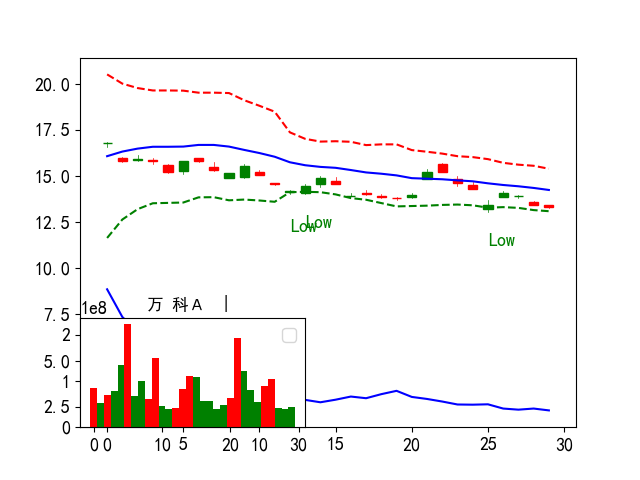

002992 1.99
xratio:1.12 ra_diff:1.99


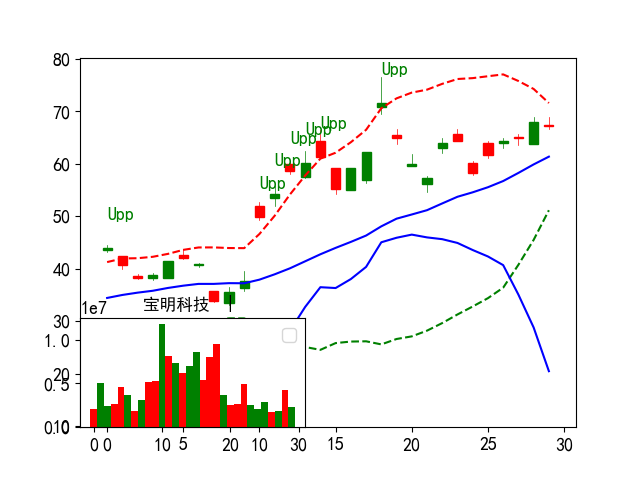

002902 1.88
xratio:0.42 ra_diff:1.88


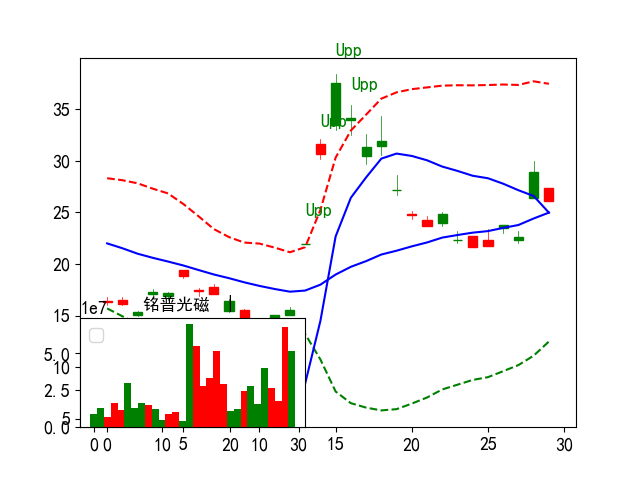

603662 1.74
xratio:0.56 ra_diff:1.74


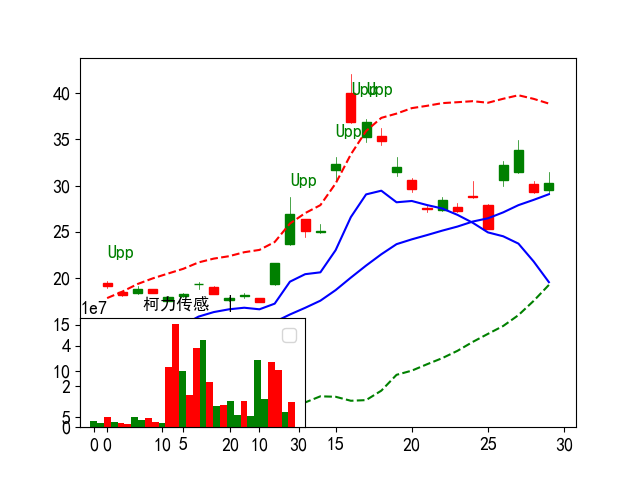

002261 1.73
xratio:0.22 ra_diff:1.73


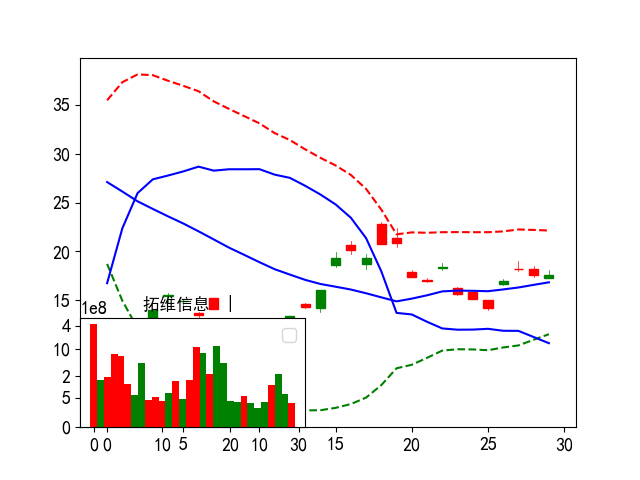

603728 1.7
xratio:1.12 ra_diff:1.7


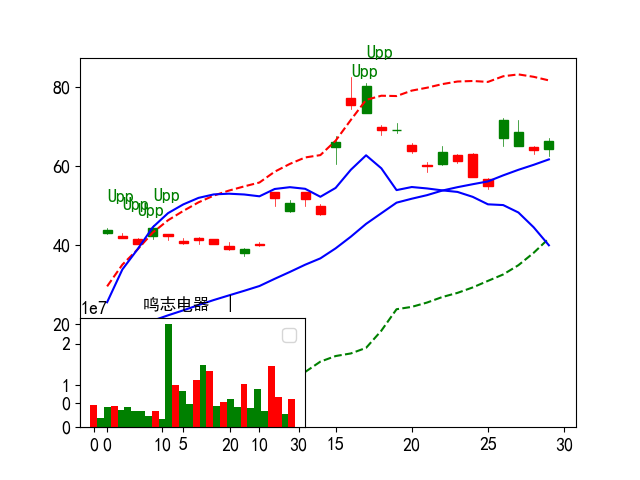

688036 1.63
xratio:1.5 ra_diff:1.63


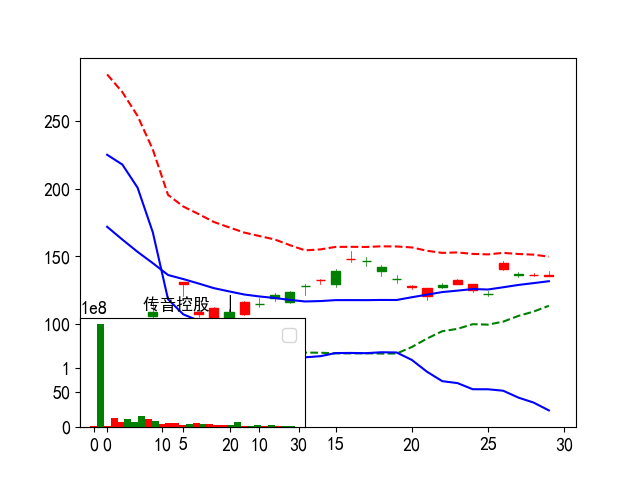

688698 1.62
xratio:0.45 ra_diff:1.62


G:\Temp\ipykernel_27220\4227828802.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


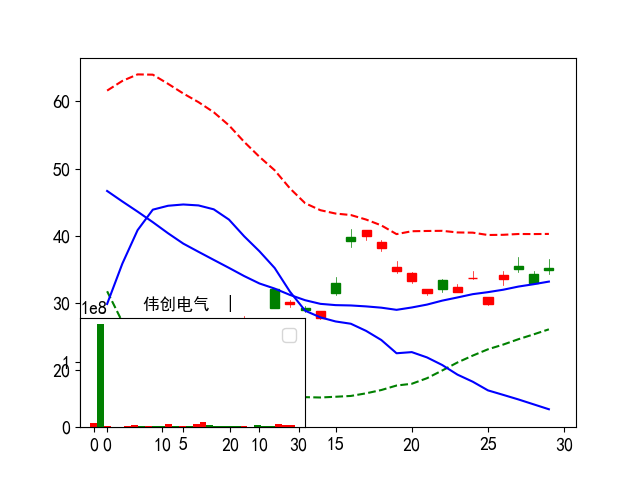

601857 1.51
xratio:0.08 ra_diff:1.51


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


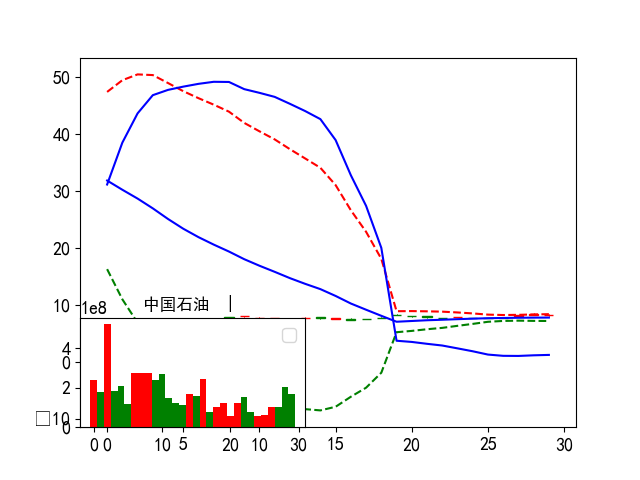

601689 1.49
xratio:0.8 ra_diff:1.49


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


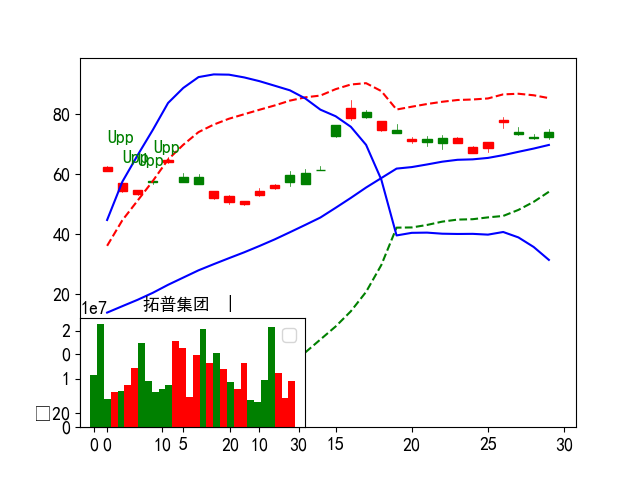

002338 1.46
xratio:0.32 ra_diff:1.46


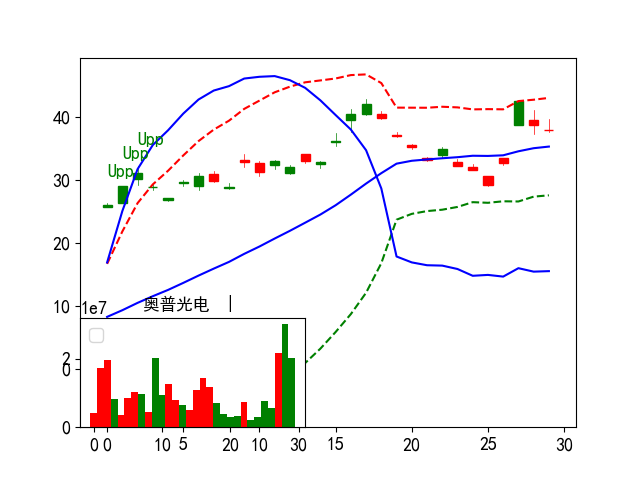

In [58]:
# dfs.loc['000002'][-60:]
show_ohlc_upper(dfs.loc['000002'][-60:],code='000002')
for co in df_mask250.index.get_level_values(0)[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfs.loc[co][-60:],code=co)

## 最近15天数据

In [59]:
dfs_tail9 = dfs.groupby(level=[0]).tail(15)

# 提取倒数第二天
# dfs_tail9 = dfs.groupby(level=[0]).tail(6)
# dfs_tail9 = dfs_tail9[dfs_tail9.index.get_level_values(1) <lastday]


# dfs_tail9.index.get_level_values(0)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# print(dfs_tail9.loc['002987'][:1])
# show_tdx_data(dfs_tail9.loc[code_t])
# dfs_tail9=compute_perd_value(dfs_tail9,market_value=5,col='vol')

# show_tdx_data(dfs_tail9.loc[code_t])
# print((dfs_tail9.loc[code_t]))

In [60]:
dfs_tail9.loc[(['999999','399001','399006'],'ra_diff')].groupby(level=0).tail(3)
# dfs_tail9.loc[pd.IndexSlice[['999999','399001','399006'], :, :]].tail(3)
# dfs_tail9.query(("code == '999999'" and "date > '2023-04-01'"))

code    date      
999999  2023-09-08    1.02
        2023-09-15    1.02
        2023-09-22    1.02
399001  2023-09-08    1.02
        2023-09-15    1.00
        2023-09-22    1.01
399006  2023-09-08    1.02
        2023-09-15    1.00
        2023-09-22    1.01
Name: ra_diff, dtype: float64

## 超跌反弹年线大于MA20

In [61]:
# show_tdx_data(dfs_tail9.loc['300418'])[-2:]
show_tdx_data(dfs_tail9.loc['603131'])[-2:]
# print(dfs_tail9.loc['603131',['high','upper','hmax']])

Count:15 30


ra_diff  xratio   idx   hat  close  volsum5d   hmax  lmin  perc1d  \
date                                                                            
2023-09-15     1.16    0.05 -0.92  3.41  13.29     347.1  14.93  11.4   -6.80   
2023-09-22     1.18    0.06  0.31  3.40  13.56     390.9  14.93  11.4    2.03   

             ma20  vol1d  vol2d   vol3d   vol4d  vol5d  perc3d  perc5d  
date                                                                    
2023-09-15  12.65 -70.34 -13.57  407.56   18.10   5.31   11.77    4.48  
2023-09-22  12.74  49.19 -70.34  -13.57  407.56  18.10   -3.69    8.05

## Run-Filter强势Upper

### filterRule test

In [62]:
# dfs_tail9.loc['002722']


def rules_to_list(rules):
    rules_l = (rules).split('&')
    for l in rules_l:
        print(l)
    return rules_l


def filter_rule_Test(dfs_tail9,resample=resample):
    col_rule = ["(dfs_tail9[('close')] > dfs_tail9[('ma5')])",
                "(dfs_tail9[('high')] > dfs_tail9.upper)",
                "(dfs_tail9[('ma5')] > dfs_tail9[('ma20')])"]
    col_rule2 = [
        "(dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(1)*0.98) | (dfs_tail9['close'] > dfs_tail9['hmax']*0.97)",
        "((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))"]
    col_rule3 = [
        "((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))"]

    col_rule_tail1 = ["(dfs_tail9.perc1d < 21)", "(dfs_tail9.perc2d > 0)"]
    if resample.upper()=='D':
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9[('close')] > dfs_tail9[('ma250')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])",
                 "(dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99)"]
    else:
        col_rule_tail2 = [
            "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
            "((dfs_tail9.volsum5d > 50) )",
            "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
            "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
        col_rule_tail3 = ["(dfs_tail9[('hmax')] > 0)",
                 "(dfs_tail9[('high')] >= dfs_tail9[('hmax')])"]
    col_rule_tail4=[ "(dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))",
             "(dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))"]
    
    col_rule.extend(col_rule2)
    col_rule.extend(col_rule3)
    col_rule.extend(col_rule_tail1)
    col_rule.extend(col_rule_tail2)
    col_rule.extend(col_rule_tail3)
    col_rule.extend(col_rule_tail4)
    
    for co in col_rule:
        print("%s:%s" % (co, eval(co)), end='')



9 0.03 0.26


'Bull'

0.26

date
2023-08-25   -0.06
2023-09-01   -0.05
2023-09-08   -0.05
2023-09-15   -0.04
2023-09-22   -0.03
Name: xratio, dtype: float64

xratio:-0.04 ra_diff:1.07


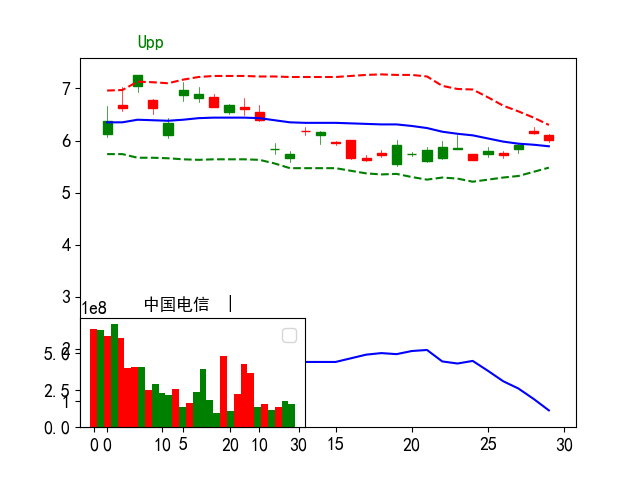

In [63]:
code_filter = '601728'


# show_tdx_data(dfs_tail9.loc[code_filter])
detect_bull_bear(dfs.loc[code_filter][-120:].close)
detect_bull_bear_apply(dfs.loc[code_filter][-120:].close)

dfs.loc[code_filter].xratio[-5:]

# filter_rule_Test(dfs_tail9.loc[code_filter])

show_ohlc_upper(dfs.loc[code_filter][-60:], code=code_filter)



In [64]:
# dfs.loc['300474'][-5:]

### 新高Hmax日见新高df_mask_hmax

#### hmax 追高

xratio:0.09 ra_diff:1.39


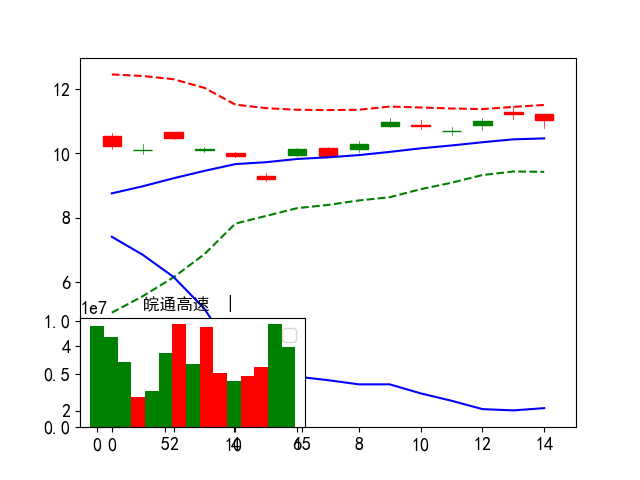

In [65]:
code='600012'
# show_tdx_data(dfs_tail9.loc[code],col='upper')
show_ohlc_upper(dfs_tail9.loc[code],code=code)

In [66]:

# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ((dfs_tail9[('hmax')] > 0) &

if resample.upper() =='D':
    mask_hmax = ( (dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(1)) &
                 ((dfs_tail9[('high')] >= dfs_tail9[('hmax')])) &
                 (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99))
                 # (dfs_tail9[('close')] > dfs_tail9.ma250 * 0.99) &
                 # (dfs_tail9[('close')] < dfs_tail9.ma250 * 1.05))
else:
    mask_hmax = ( (dfs_tail9[('low')] >= dfs_tail9[('ma5')].shift(1))  &
              (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1))  ) 

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & (dfs_tail9[('close')] > dfs_tail9.ma20 *0.99) & (dfs_tail9[('close')] < dfs_tail9.ma20 *1.20) )


df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]
df_mask_hmax = get_multi_code_count(df_mask_hmax)

# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

# df_mask_hmax.couts.std()

df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')

df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['couts','volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0,0, 0, 0, 0])
    # by=['volsum5d', 'idx', 'hat', 'perc1d'],ascending=[0, 0, 0, 0])
# print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['300461'])
df_mask_hmax.couts[:1], df_mask_hmax.shape
show_tdx_data(df_mask_hmax)[:10]
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)]).T

count dd.couts
compute percent


(code
 000046    11
 Name: couts, dtype: int64,
 (743, 40))

Count:743 40


name  couts       date  perc  ra_diff  xratio   idx    hat  close  \
code                                                                         
000046  *ST泛海     11 2023-09-22  5.02     3.24    0.07  1.61   2.40   2.93   
002494   华斯股份     11 2023-09-22 -0.78     1.23    0.03  0.28   0.96   5.11   
603949   雪龙集团     11 2023-09-22  0.08     1.74    0.32  8.47  11.89  24.72   
002355   兴民智通     11 2023-09-22 -5.26     1.93    0.15  1.32   4.31   6.84   
603813   原尚股份     10 2023-09-22 -0.32     1.15    0.06  0.73   2.45  15.57   
300289    利德曼     10 2023-09-22  0.00     1.10    0.01  0.23   0.60   5.99   
600889   南京化纤     10 2023-09-22 -0.96     1.20    0.03  0.33   0.99   5.16   
002370   亚太药业     10 2023-09-22 -0.87     1.14    0.01  0.32   0.76   4.55   
600235   民丰特纸     10 2023-09-22 -0.86     1.14    0.02  0.26   0.71   5.79   
603903   中持股份     10 2023-09-22  0.82     1.12    0.01  0.66   1.13   9.84   

        volsum5d  ...   ma20  nclose   llow   vol1d   vol2d  vol3d   vol4d  \
code              ...                                                        
000046     126.3  ...   1.44    2.92   2.57  111.71   37.52  35.90  -38.44   
002494      91.2  ...   4.77    5.12   4.99   74.89   54.03 -38.63   -0.03   
603949      34.0  ...  17.21   24.70  23.30   -5.23   -1.34  79.13  -25.92   
002355     -32.9  ...   5.43    6.93   6.93   40.13  -41.33   1.44    3.71   
603813     111.7  ...  14.69   15.62  15.33   74.64  -39.25 -33.41  179.18   
300289     107.4  ...   5.74    6.00   5.92  -26.09  182.84 -21.19   37.77   
600889      18.7  ...   4.86    5.18   5.13  -12.78  -39.25  72.87    6.07   
002370     -13.8  ...   4.32    4.57   4.54  -43.09  186.27 -36.05  -46.05   
600235     -17.6  ...   5.53    5.80   5.73   10.68   12.93 -48.04   37.89   
603903     -20.0  ...   9.27    9.85   9.66  -18.06  -14.73 -52.09   17.19   

        vol5d  perc3d  perc5d  
code                           
000046 -20.34   43.08   51.63  
002494   0.92    2.18    3.41  
603949 -12.69   28.38   39.15  
002355 -36.84   11.94   17.59  
603813 -69.44    0.58    1.96  
300289 -65.96    2.74    3.99  
600889  -8.21    5.04    2.16  
002370 -74.89    2.00   -0.86  
600235 -31.08    1.57    2.82  
603903  47.64    0.41    4.72  

[10 rows x 23 columns]

#### hmax Top upper > 1

In [67]:
# dfs_tail9.loc['600103']

In [68]:
# mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] > dfs_tail9[('hmax')].shift(
#     1) * 0.99) | (dfs_tail9['high'] > dfs_tail9['hmax'] * 0.99)) )

# mask_hmax = ( (dfs_tail9[('hmax')] > 0) & ((dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) ) )
# mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) )
if resample.upper() == 'D':
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('high')] >= dfs_tail9[('hmax')]*0.99) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )
else:
    mask_hmax = (  (dfs_tail9[('high')] >= dfs_tail9[('high')].shift(1)) & 
                 (dfs_tail9[('high')].shift(1) >= dfs_tail9[('high')].shift(2)) &
                (dfs_tail9[('close')] >= dfs_tail9[('upper')].shift(1)) )

df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]

#站上Upper
# df_mask_hmax = df_mask_hmax[ (df_mask_hmax[('close')] > df_mask_hmax.upper)]

df_mask_hmax = get_multi_code_count(df_mask_hmax)
df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')



df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],
# code_t = '000534'
df_mask_hmax = df_mask_hmax.sort_values(
    by=['volsum5d', 'idx', 'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc['000039'])
df_mask_hmax.couts[:1], df_mask_hmax.shape
# show_tdx_data(df_mask_hmax).T
# show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)])

show_tdx_data(df_mask_hmax[(df_mask_hmax.couts > 1)] )[:10]

count dd.couts
compute percent
code
000752    6
Name: couts, dtype: int64 (72, 40)


(code
 000752    6
 Name: couts, dtype: int64,
 (72, 40))

Count:54 40


name  couts       date   perc  ra_diff  xratio    idx    hat  close  \
code                                                                           
000752  *ST西发      6 2023-09-22   4.98     2.86    0.27   6.16   9.23  11.17   
600408   安泰集团      2 2023-09-22  -9.94     1.62    0.01   1.10   1.22   3.08   
600189    泉阳泉      5 2023-09-22  -6.52     1.69    0.13   3.27   5.09   9.18   
605088   冠盛股份      2 2023-09-22  -7.62     1.55    0.27   7.31  10.41  22.31   
001268   联合精密      3 2023-09-22 -10.00     1.84    0.30  14.92  19.88  33.30   
002889   东方嘉盛      2 2023-09-22  -9.99     1.58   -0.13   7.83  11.84  25.23   
002547   春兴精工      2 2023-09-22  -2.05     1.43    0.02   1.30   1.70   5.73   
600844   丹化科技      2 2023-09-22   0.66     1.13    0.00   0.16   0.39   3.06   
300955   嘉亨家化      3 2023-09-22  -6.89     1.27    0.09   4.34   5.84  23.93   
002194   武汉凡谷      2 2023-09-22  -7.08     1.35   -0.01   1.95   3.57  10.76   

        volsum5d  ...   ma20  nclose   llow    vol1d    vol2d    vol3d  vol4d  \
code              ...                                                           
000752    5304.8  ...   5.93   11.17  10.00  5365.20   -95.80   -37.53  16.58   
600408    2034.4  ...   2.44    3.10   3.10   -23.81  1948.87   -50.87  83.90   
600189    1454.1  ...   6.96    9.50   9.78   130.16   -26.70  1130.16 -70.55   
605088    1034.1  ...  18.05   22.25  22.70   199.61   202.90   -56.02 -54.71   
001268     992.1  ...  23.78   34.69  36.02    70.40   403.89   583.33 -34.09   
002889     945.4  ...  21.43   25.65  27.61   -29.80    58.20  1007.38 -35.93   
002547     932.5  ...   4.60    5.82   5.16    32.38   112.83   795.27 -16.67   
600844     890.2  ...   2.82    3.05   2.99   -29.49   894.91   -60.92  72.29   
300955     881.5  ...  22.09   24.08  24.08    38.36   295.14   -53.77 -70.07   
002194     831.6  ...   9.93   10.84  11.43   166.42   535.98    94.40 -47.37   

         vol5d  perc3d  perc5d  
code                            
000752   56.30   36.41   16.41  
600408   76.31   38.46   42.50  
600189  291.05   46.35   41.29  
605088  742.34   10.58   44.87  
001268  -31.38   69.18   69.18  
002889  -54.41   48.07   45.69  
002547    8.65   36.68   37.65  
600844   13.42   12.59    7.42  
300955  671.81    9.08   19.42  
002194   82.16   26.97   28.95  

[10 rows x 23 columns]

In [69]:
# show_tdx_data(df_mask_hmax.loc['600103'][-5:])

##### sort_values

In [70]:
show_tdx_data(
    df_mask_hmax.sort_values(
        by=['ra_diff', 'couts', 'idx'],
        ascending=[0, 0, 0]),col='ra_diff')[:20]

Count:72 40


name  couts       date   perc  ra_diff  ra_diff  xratio    idx  \
code                                                                      
000046  *ST泛海      7 2023-09-22   5.02     3.24     3.24    0.07   1.61   
000766   通化金马      3 2023-09-22  -1.33     2.90     2.90    0.20   8.13   
000752  *ST西发      6 2023-09-22   4.98     2.86     2.86    0.27   6.16   
300108  *ST吉药      4 2023-09-22   4.25     2.35     2.35    0.07   1.07   
300606    金太阳      3 2023-09-22   0.66     2.06     2.06    0.41   9.52   
601127    赛力斯      2 2023-09-22   3.14     2.05     2.05    0.78  10.00   
001268   联合精密      3 2023-09-22 -10.00     1.84     1.84    0.30  14.92   
300049   福瑞股份      2 2023-09-22  -6.19     1.79     1.79   -0.15  16.00   
603949   雪龙集团      6 2023-09-22   0.08     1.74     1.74    0.32   8.47   
600706   曲江文旅      2 2023-09-22  -6.10     1.74     1.74   -0.03   2.84   
300840   酷特智能      4 2023-09-22  -4.07     1.70     1.70    0.14   3.66   
600189    泉阳泉      5 2023-09-22  -6.52     1.69     1.69    0.13   3.27   
000010   美丽生态      2 2023-09-22   6.96     1.67     1.67    0.04   0.98   
600408   安泰集团      2 2023-09-22  -9.94     1.62     1.62    0.01   1.10   
601188   龙江交通      2 2023-09-22   9.94     1.61     1.61    0.03   1.54   
002889   东方嘉盛      2 2023-09-22  -9.99     1.58     1.58   -0.13   7.83   
605088   冠盛股份      2 2023-09-22  -7.62     1.55     1.55    0.27   7.31   
600540   新赛股份      4 2023-09-22   2.77     1.48     1.48    0.08   0.87   
601666   平煤股份      2 2023-09-22  -1.75     1.48     1.48   -0.02   3.12   
605128   上海沿浦      3 2023-09-22   1.03     1.46     1.46    0.50   8.45   

          hat  close  ...   ma20  nclose   llow    vol1d    vol2d    vol3d  \
code                  ...                                                    
000046   2.40   2.93  ...   1.44    2.92   2.57   111.71    37.52    35.90   
000766   9.72  13.34  ...   6.30   13.37  12.65   153.70   124.57   -71.85   
000752   9.23  11.17  ...   5.93   11.17  10.00  5365.20   -95.80   -37.53   
300108   2.21   3.68  ...   2.49    3.68   3.41    17.79   148.93     2.50   
300606  12.61  27.47  ...  19.79   27.18  24.18   185.03    28.21   -51.22   
601127  30.57  52.60  ...  37.17   52.42  48.00   -46.78    71.19    19.52   
001268  19.88  33.30  ...  23.78   34.69  36.02    70.40   403.89   583.33   
300049  17.08  34.99  ...  25.81   35.11  31.10   202.11   -10.62     0.93   
603949  11.89  24.72  ...  17.21   24.70  23.30    -5.23    -1.34    79.13   
600706   4.96  18.77  ...  17.07   18.94  18.56     5.42    33.49   213.73   
300840   5.49  15.54  ...  13.16   15.79  15.66    48.71   -67.44     9.30   
600189   5.09   9.18  ...   6.96    9.50   9.78   130.16   -26.70  1130.16   
000010   1.83   3.69  ...   2.66    3.71   3.23     1.21   335.07   -52.99   
600408   1.22   3.08  ...   2.44    3.10   3.10   -23.81  1948.87   -50.87   
601188   1.77   5.42  ...   3.46    5.42   4.87    -4.07   163.46   629.08   
002889  11.84  25.23  ...  21.43   25.65  27.61   -29.80    58.20  1007.38   
605088  10.41  22.31  ...  18.05   22.25  22.70   199.61   202.90   -56.02   
600540   2.43   6.30  ...   5.07    6.27   5.80     4.87    24.78    26.28   
601666   4.59  10.65  ...   8.52   10.72  10.68   -35.23    81.22   -58.84   
605128  15.96  51.12  ...  41.81   50.75  46.82   163.96     4.76   141.49   

         vol4d   vol5d  perc3d  perc5d  
code                                    
000046  -38.44  -20.34   43.08   51.63  
000766  397.81  -55.81   86.23  148.53  
000752   16.58   56.30   36.41   16.41  
300108   -3.60  -55.48   20.07   32.21  
300606  285.90  -47.24   20.22   33.19  
601127  114.82  -28.58   38.25   45.55  
001268  -34.09  -31.38   69.18   69.18  
300049  157.93  -35.15   42.26   72.05  
603949  -25.92  -12.69   28.38   39.15  
600706   38.33   -8.05   24.01   29.97  
300840   67.84   74.32   12.11   26.17  
600189  -70.55  291.05   46.35   41.29  
000010  -56.02   10.72    9.18    9.18  
600408   83.90   76.31   3

xratio:0.17 ra_diff:1.19


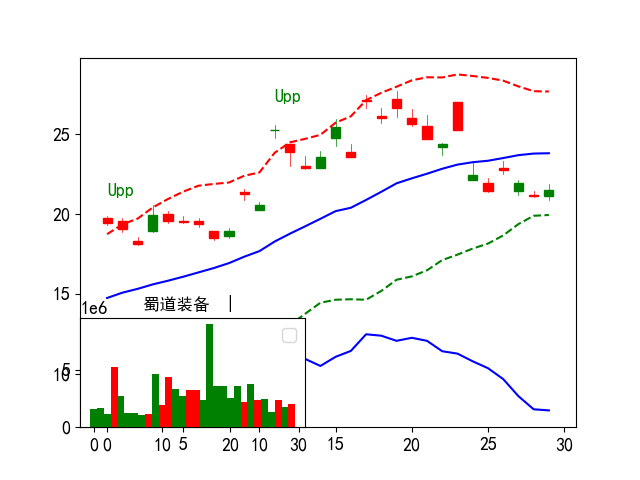

In [71]:
show_ohlc_upper(dfs.loc['300540'][-60:],code='300540')

### df_mask250 upper xratio

In [72]:

if resample.upper() =='D':
    mask250 = ((dfs_tail9[('high')] > dfs_tail9.upper) &
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift( 1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['close'] > dfs_tail9[('hmax')]) &
                (dfs_tail9[('close')] > dfs_tail9[('ma250')]) | ((dfs_tail9[('high')] > dfs_tail9.upper) &
                                                                 (dfs_tail9[('close')] > dfs_tail9[('ma5')])) &
               (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('close')] > dfs_tail9[('ma250')])
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
elif resample.upper() =='W' or resample == 'W-FRI':
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
               & (dfs_tail9[('xratio')] > dfs_tail9[('xratio')].shift(1))
               & (dfs_tail9[('xratio')].shift(1) > dfs_tail9[('xratio')].shift(2))
              )
else:
    mask250 = (
               (dfs_tail9[('close')] > dfs_tail9[('ma5')])
               & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
               & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
               & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
               & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
              )

# & (dfs_tail9[('close')] < dfs_tail9[('ma20'  )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail9.loc[idx[mask250, :]]
df_mask250.shape
#站上Upper
df_mask250 = df_mask250[ (df_mask250[('close')] > df_mask250.upper)]

df_mask250 = get_multi_code_count(df_mask250)


code_t = '603131'
print((df_mask250.couts[:3], df_mask250.shape))
# df_mask250.loc[code_t]
groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1).reset_index().set_index('code')
# df_mask250 = get_sina_data_cname(df_mask250, dm,realtime=True)



# df_mask250.loc[code_t].close
df_mask250 = get_sina_data_cname(df_mask250, realtime=True)
# df_mask250.loc[code_t].close

df_mask250 = clean_688(df_mask250)
# df_masklastd.loc['002722']

df_mask250 = df_mask250.sort_values(
    by=['idx','xratio',  'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
    # by=['xratio', 'idx', 'hat', 'perc1d'],

# by=['perc', 'perc5d', 'perc1d'],
# ascending=[0, 0, 0])
print("df_mask250:%s df_mask_hmax:%s"%(len(df_mask250),len(df_mask_hmax)))
cross_hmax_250 = [co for co in df_mask250.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))

show_tdx_data(df_mask250[df_mask250.couts > 1])
# show_tdx_data(df_mask250.loc[code_t])

(1069, 30)

count dd.couts
(code    date      
603949  2023-08-25    5
        2023-09-01    5
        2023-09-08    5
Name: couts, dtype: int64, (290, 31))
compute percent
df_mask250:211 df_mask_hmax:72
cross_hamx:43
Count:50 40


name  couts       date   perc  ra_diff  xratio    idx    hat  close  \
code                                                                           
301218   华是科技      2 2023-08-25  -2.99     2.76    0.88  32.59  38.84  40.54   
301159   三维天地      2 2023-08-25  -1.61     1.93    0.46  22.47  27.55  48.20   
002855   捷荣技术      3 2023-09-22   3.33     3.00    0.46  15.91  21.47  27.00   
001268   联合精密      2 2023-09-22 -10.00     1.84    0.30  14.92  19.88  33.30   
603198   迎驾贡酒      2 2023-09-01  -0.52     1.38    0.45  14.29  23.17  74.67   
600895   张江高科      2 2023-09-15  -5.28     2.08    0.14  12.10  11.94  22.59   
603220   中贝通信      3 2023-09-08  -1.77     2.07    0.43  11.64  15.62  23.25   
603985   恒润股份      2 2023-09-01   0.51     1.59    0.23   9.43  10.92  25.77   
603160   汇顶科技      3 2023-09-22  -3.63     1.41    0.40   9.04  23.33  62.64   
603949   雪龙集团      5 2023-09-22   0.08     1.74    0.32   8.47  11.89  24.72   
000766   通化金马      4 2023-09-22  -1.33     2.90    0.20   8.13   9.72  13.34   
300293   蓝英装备      2 2023-09-15   3.19     2.02    0.09   7.72   9.25  18.75   
603607   京华激光      2 2023-09-15 -10.02     1.66    0.15   7.59   7.47  17.78   
605088   冠盛股份      3 2023-09-22  -7.62     1.55    0.27   7.31  10.41  22.31   
605365    立达信      2 2023-09-15  -8.68     1.61    0.04   7.19   7.20  18.51   
301004   嘉益股份      2 2023-09-08  -1.54     1.67    0.60   7.18  19.37  45.40   
603919    金徽酒      2 2023-09-15  -0.74     1.29    0.09   6.12   6.85  29.38   
603569   长久物流      2 2023-08-18   5.25     1.98    0.21   6.05   7.75  14.63   
000752  *ST西发      2 2023-09-15   4.98     2.72    0.23   5.96   8.26  11.17   
000786   北新建材      2 2023-09-08  -0.10     1.31    0.10   5.81   8.43  30.18   
603979    金诚信      3 2023-09-15   0.15     1.31    0.23   5.71  10.15  38.88   
301178    天亿马      2 2023-09-08  -4.02     1.27   -0.03   5.57   7.67  31.77   
002353   杰瑞股份      2 2023-09-22   3.85     1.32    0.22   5.04   9.85  33.16   
605318    法狮龙      2 2023-09-08  -1.08     1.47    0.15   4.58   5.50  18.29   
605068   明新旭腾      3 2023-09-22   3.25     1.31    0.14   4.42   7.00  27.98   
300955   嘉亨家化      2 2023-09-22  -6.89     1.27    0.09   4.34   5.84  23.93   
300965    NaN      2 2023-09-15    NaN     1.38    0.33   4.10  17.12  57.80   
600546   山煤国际      3 2023-09-15   0.73     1.46    0.09   3.67   6.51  19.45   
300840   酷特智能      2 2023-09-22  -4.07     1.70    0.14   3.66   5.49  15.54   
600114   东睦股份      3 2023-09-08   0.38     1.62    0.07   3.55   4.57  10.45   
300796    贝斯美      4 2023-09-22  -1.00     1.28    0.04   2.75   3.27  13.85   
000962   东方钽业      2 2023-09-22  -9.97     1.37    0.07   2.55   4.17  13.19   
600186   莲花健康      2 2023-09-22  -0.57     1.99    0.08   2.24   3.09   5.19   
000975   银泰黄金      2 2023-09-15  -0.20     1.30    0.06   2.22   3.78  14.76   
300691   联合光电      2 2023-09-15  -2.36     1.38    0.13   2.11   5.60  18.21   
300414   中光防雷      2 2023-09-08  -2.63     1.41    0.08   2.07   3.54  10.37   
600203   福日电子      2 2023-09-22 -10.04     1.43    0.01   1.93   2.07   7.08   
002750   龙津药业      2 2023-09-22  -1.99     1.25    0.03   1.90   2.46  10.86   
600589  *ST榕泰      2 2023-09-15   3.59     2.90    0.07   1.87   2.91   4.90   
601808   中海油服      2 2023-09-15  -0.24     1.23    0.01   1.81   2.98  16.66   
000058  深 赛 格      3 2023-09-22 -10.02     1.38    0.06   1.69   2.57   7.45   
600322   天房发展      2 2023-09-01  -2.99     1.97    0.05   1.69   2.17   2.60   
603602   纵横通信      3 2023-09-22  -0.22     1.14    0.02   1.63   2.03  13.52   
000046  *ST泛海      2 2023-09-15   5.02     3.15    0.06   1.55   2.09   2.93   
600351   亚宝药业      2 2023-09-22  -1.80     1.24    0.04   1.39   1.84   8.19   
002547   春兴精工      2 2023-09-22  -2.05     1.43    0.02   1.30   1.70   5.73   
300139   晓程科技      2 2023-09-15   1.03     1.21   -0.01   1.22   2.01  10.79   
000428   华天酒店      2 2023-09-22  -5.19     1.35    0.02   1.19   1.64   5.30   
300562   

df_mask250:50
301218 2.06
xratio:0.91 ra_diff:2.06


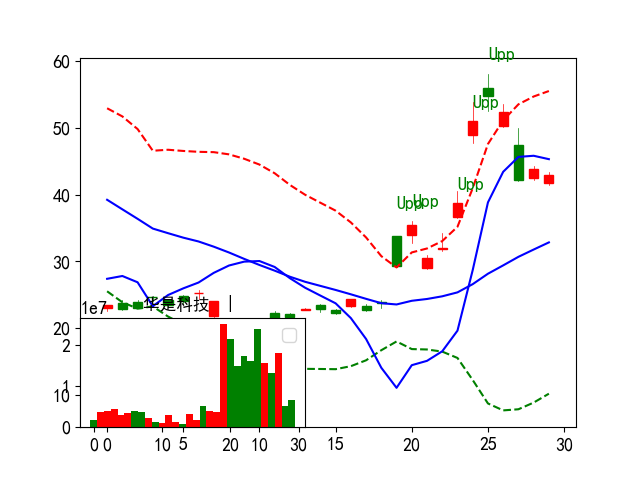

301159 1.48
xratio:0.52 ra_diff:1.48


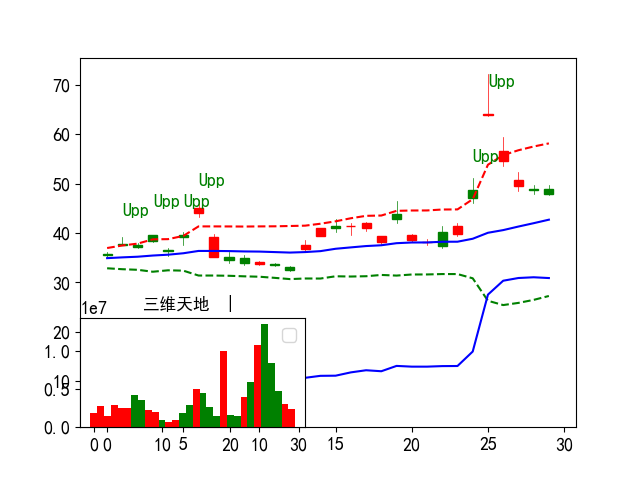

002855 3.0
xratio:0.28 ra_diff:3.0


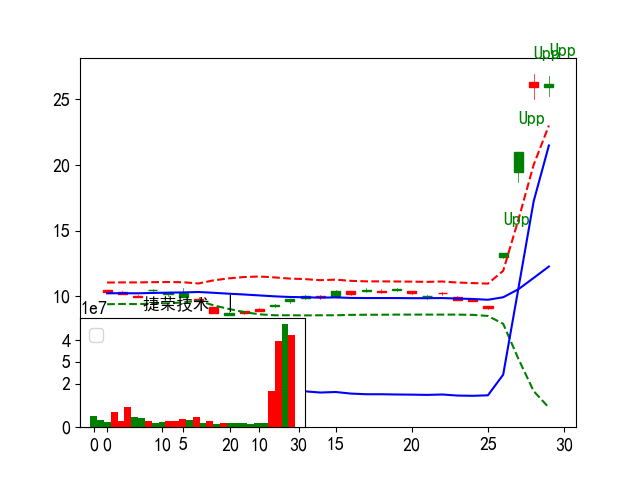

001268 1.84
xratio:0.12 ra_diff:1.84


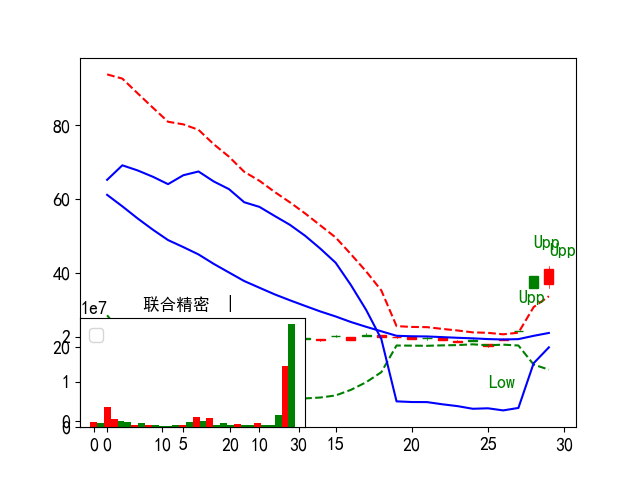

603198 1.32
xratio:0.39 ra_diff:1.32


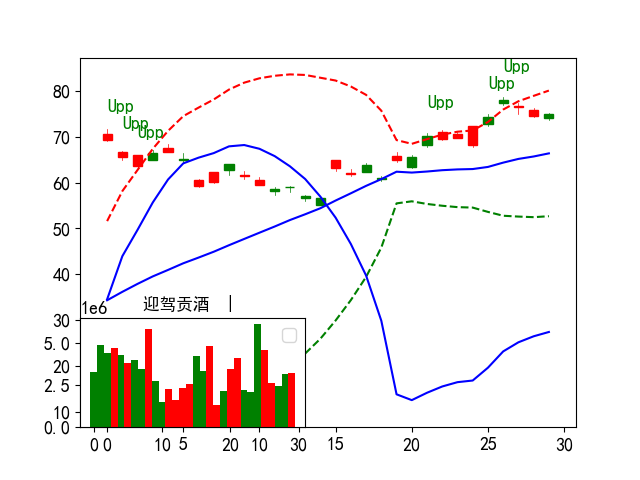

600895 1.89
xratio:0.14 ra_diff:1.89


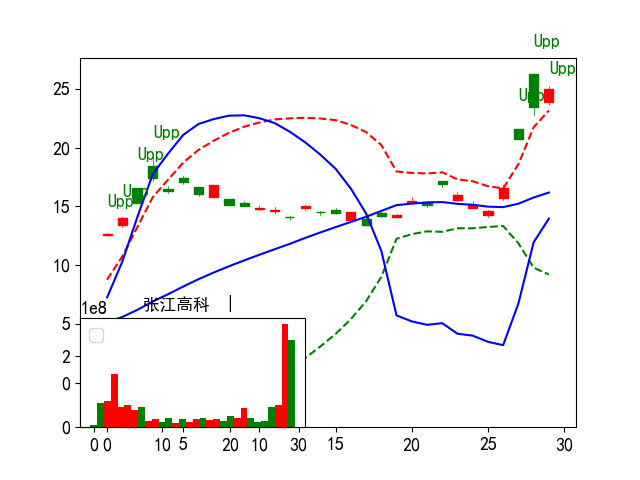

603220 1.82
xratio:0.38 ra_diff:1.82


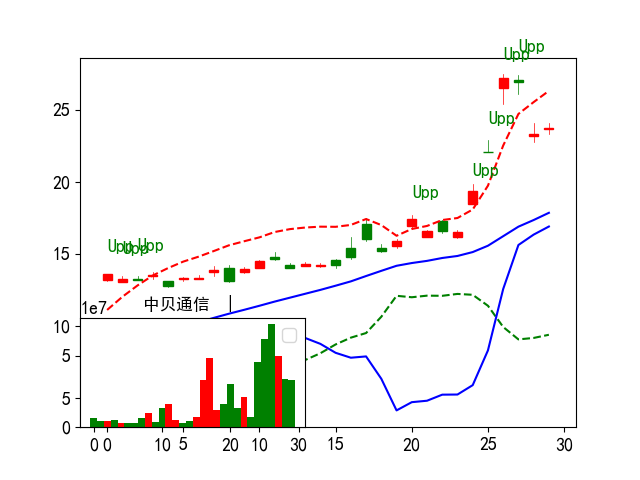

603985 1.34
xratio:0.12 ra_diff:1.34


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


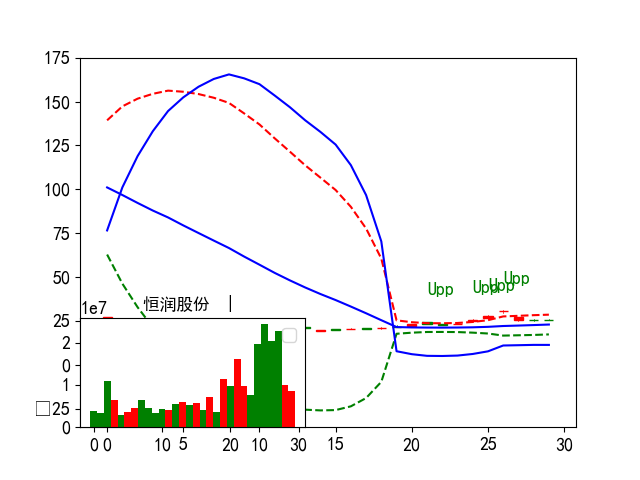

603160 1.41
xratio:0.1 ra_diff:1.41


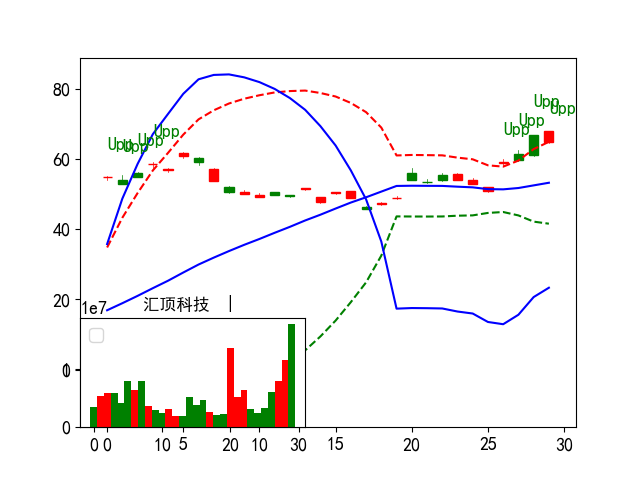

603949 1.74
xratio:0.16 ra_diff:1.74


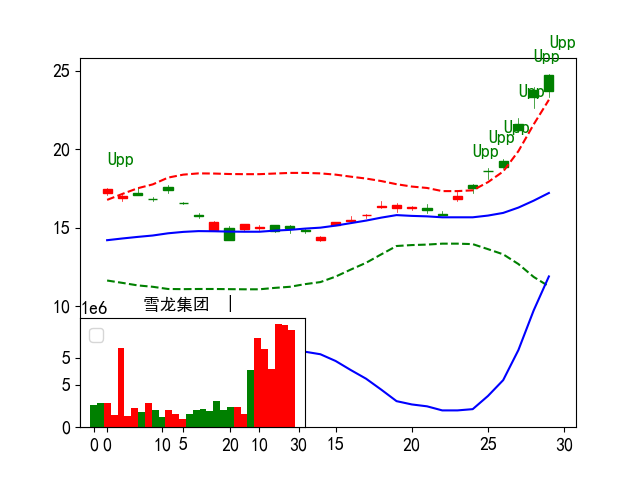

In [73]:
print("df_mask250:%s"%(len(df_mask250[df_mask250.couts > 1])))
for co in df_mask250[df_mask250.couts > 1].index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfs.loc[co][-60:],code=co)

### Tail1 Show Top 主升浪df_masklastd

In [74]:
df_mask250[(df_mask250.date >= lastday_week)][:2]
df_mask250[df_mask250.ra_diff > 1.3].shape

date   lopen   lhigh    llow   close         vol        amount  \
code                                                                          
301218 2023-08-25   54.79   58.00   52.50   40.54  15571298.0  8.634241e+08   
605499 2023-09-01  194.27  200.54  186.88  184.45    962820.0  1.880018e+08   

        ra_diff     ma5   ma10  ...    idx  couts  nclose  name    open  \
code                            ...                                       
301218     2.76   40.49   34.1  ...  32.59      2   40.51  华是科技   41.20   
605499     1.22  185.04  182.2  ...  24.10      1  183.92  东鹏饮料  185.72   

          high     low  llastp            ticktime  perc  
code                                                      
301218   41.40   40.10   41.79 2023-09-19 15:00:03 -2.99  
605499  185.72  183.17  185.33 2023-09-19 15:00:00 -0.47  

[2 rows x 40 columns]

(135, 40)

In [75]:
# df_masklastd = df_mask250[(df_mask250.date >= '2023-02-06') & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0) &
if resample.upper() =='D':
    df_masklastd = df_mask250[(df_mask250.date >= lastday) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 10) & (df_mask250.close > df_mask250.ma5) )
                          ]
                          # & ((df_mask250.perc3d > 0) | ((df_mask250.close.shift(2) > df_mask250.ma5.shift(2))) )
else:
    df_masklastd = df_mask250[(df_mask250.date >= lastday_week) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 20) & (df_mask250.close > df_mask250.ma5) )
                          ]
# (df_mask250.couts == 1) & (df_mask250.perc1d < 21)]

#当下大于上轨
df_masklastd = df_masklastd[df_masklastd.close > df_masklastd.ma5]

print("src:%s  lastd:%s " % (df_mask250.shape, df_masklastd.shape))


if resample.upper() =='M':
    df_masklastd = df_masklastd.sort_values(
        by=['perc1d', 'perc3d'],
        ascending=[0, 0])
else:
    df_masklastd = df_masklastd.sort_values(
        by=['perc3d', 'perc1d'],
        ascending=[0, 0])

# print(
#     (df_masklastd.loc
#      [:, ['name', 'couts', 'date', 'perc1d', 'perc3d', 'perc5d']][:10],
#      df_masklastd.shape,))

show_tdx_data(df_masklastd)
show_tdx_data(df_masklastd[-10:])


code_t = '300675'
code_t = '605268'
code_t = '002828'
code_t = '300418'
code_t = df_masklastd.index[0]


# df_masklastd.loc[code_t, ['name', 'couts',
#                           'date', 'perc1d', 'perc3d', 'perc5d']]

# df_masklastd.loc[code_t].date


# df_mask250 = groupd250.head(1)

# df_masklastd.loc[code_t].date
# show_tdx_data(df_masklastd.loc[code_t])


# show_tdx_data(df_masklastd.loc[code_t])

src:(211, 40)  lastd:(109, 40) 
Count:109 40


name  couts       date   perc  ra_diff  xratio    idx    hat  close  \
code                                                                          
300293  蓝英装备      2 2023-09-15   3.19     2.02    0.09   7.72   9.25  18.75   
000536  华映科技      1 2023-09-15  10.03     1.99    0.02   1.62   1.84   3.73   
002855  捷荣技术      3 2023-09-22   3.33     3.00    0.46  15.91  21.47  27.00   
000766  通化金马      4 2023-09-22  -1.33     2.90    0.20   8.13   9.72  13.34   
603326  我乐家居      1 2023-09-08   3.10     1.85    0.08   5.99   6.44  12.99   
...      ...    ...        ...    ...      ...     ...    ...    ...    ...   
600862  中航高科      1 2023-09-08  -2.47     1.19    0.13   1.06   3.97  24.84   
003023  彩虹集团      1 2023-09-01  -1.76     1.22    0.07   2.36   3.85  22.28   
000096  广聚能源      1 2023-09-08   2.02     1.12    0.02   0.66   1.04   9.09   
002750  龙津药业      2 2023-09-22  -1.99     1.25    0.03   1.90   2.46  10.86   
301096  百诚医药      1 2023-09-22  -0.52     1.10   -0.16   5.50   6.01  64.67   

        volsum5d  ...   ma20  nclose   llow    vol1d   vol2d   vol3d   vol4d  \
code              ...                                                          
300293     826.2  ...  11.50   18.76  18.30     6.36  368.00  445.78   26.18   
000536     895.0  ...   2.03    3.63   3.33    49.45  134.18  697.46   -8.84   
002855     916.5  ...  12.26   26.25  25.26   -11.19   20.77  136.88  758.33   
000766     548.4  ...   6.30   13.37  12.65   153.70  124.57  -71.85  397.81   
603326    3311.3  ...   8.41   12.89  13.40  3230.68   87.31   43.34  -26.54   
...          ...  ...    ...     ...    ...      ...     ...     ...     ...   
600862     347.5  ...  23.87   24.91  25.09   325.27  -45.36  -43.74  133.09   
003023     930.1  ...  20.47   22.46  22.57    10.20   24.34  -51.56  982.26   
000096      58.4  ...   8.28    9.11   8.68    11.12   52.70   -2.29  -39.63   
002750     435.2  ...   9.73   11.06  10.78    10.85   60.00  -77.34  409.50   
301096     275.6  ...  61.63   64.57  63.52   -16.81  303.96  -60.68   66.72   

        vol5d  perc3d  perc5d  
code                           
300293 -20.08  102.13   90.35  
000536  22.78   97.75   87.23  
002855  11.74   96.32  171.34  
000766 -55.81   86.23  148.53  
603326 -23.51   73.56   66.27  
...       ...     ...     ...  
600862 -21.73    4.60    7.15  
003023 -35.10    4.57    9.37  
000096  36.46    4.26    2.92  
002750  32.23    3.84   15.30  
301096 -17.61    3.03    5.36  

[109 rows x 23 columns]

Count:10 40


name  couts       date  perc  ra_diff  xratio   idx   hat  close  \
code                                                                       
605155   西大门      1 2023-09-08  0.52     1.18    0.07  1.21  2.32  15.50   
605090  九丰能源      1 2023-09-01  0.74     1.10    0.03  1.39  2.49  23.19   
002287  奇正藏药      1 2023-09-22 -0.91     1.12   -0.05  2.10  2.83  25.15   
300945   曼卡龙      1 2023-09-22 -3.51     1.27    0.08  0.19  3.24  16.47   
300703  创源股份      1 2023-09-08 -0.98     1.16   -0.00  0.98  1.51  10.15   
600862  中航高科      1 2023-09-08 -2.47     1.19    0.13  1.06  3.97  24.84   
003023  彩虹集团      1 2023-09-01 -1.76     1.22    0.07  2.36  3.85  22.28   
000096  广聚能源      1 2023-09-08  2.02     1.12    0.02  0.66  1.04   9.09   
002750  龙津药业      2 2023-09-22 -1.99     1.25    0.03  1.90  2.46  10.86   
301096  百诚医药      1 2023-09-22 -0.52     1.10   -0.16  5.50  6.01  64.67   

        volsum5d  ...   ma20  nclose   llow   vol1d   vol2d  vol3d   vol4d  \
code              ...                                                        
605155     226.9  ...  14.50   15.46  15.71  -55.01  315.12 -40.45   23.89   
605090     303.7  ...  22.41   23.23  23.33   -2.21   14.25 -70.32  347.91   
002287     191.9  ...  23.83   25.33  24.55   91.42  146.82 -42.66   22.11   
300945     593.6  ...  15.36   16.65  16.61   -7.15  373.72 -68.16  227.33   
300703     440.0  ...   9.62   10.16  10.35  -35.21   74.16 -67.18  491.13   
600862     347.5  ...  23.87   24.91  25.09  325.27  -45.36 -43.74  133.09   
003023     930.1  ...  20.47   22.46  22.57   10.20   24.34 -51.56  982.26   
000096      58.4  ...   8.28    9.11   8.68   11.12   52.70  -2.29  -39.63   
002750     435.2  ...   9.73   11.06  10.78   10.85   60.00 -77.34  409.50   
301096     275.6  ...  61.63   64.57  63.52  -16.81  303.96 -60.68   66.72   

        vol5d  perc3d  perc5d  
code                           
605155 -16.61    5.91    8.16  
605090  14.05    5.66    2.60  
002287 -25.82    5.57    8.18  
300945  67.90    5.50   15.10  
300703 -22.89    4.80    7.37  
600862 -21.73    4.60    7.15  
003023 -35.10    4.57    9.37  
000096  36.46    4.26    2.92  
002750  32.23    3.84   15.30  
301096 -17.61    3.03    5.36  

[10 rows x 23 columns]

### df_mask_hmax 061

df_mask_hmax:72
000752 2.86
xratio:0.19 ra_diff:2.86


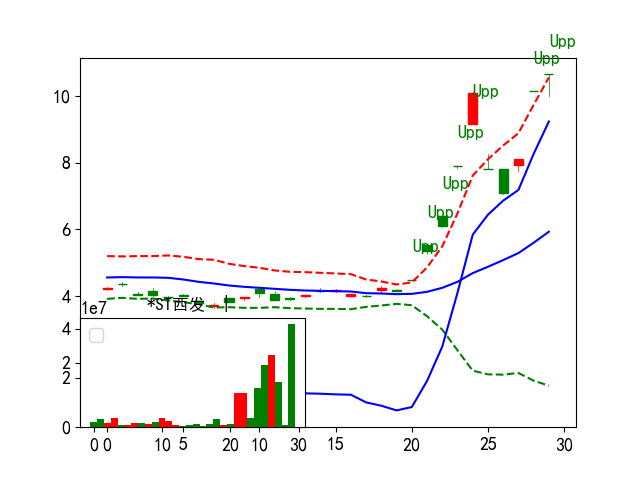

600408 1.62
xratio:0.0 ra_diff:1.62


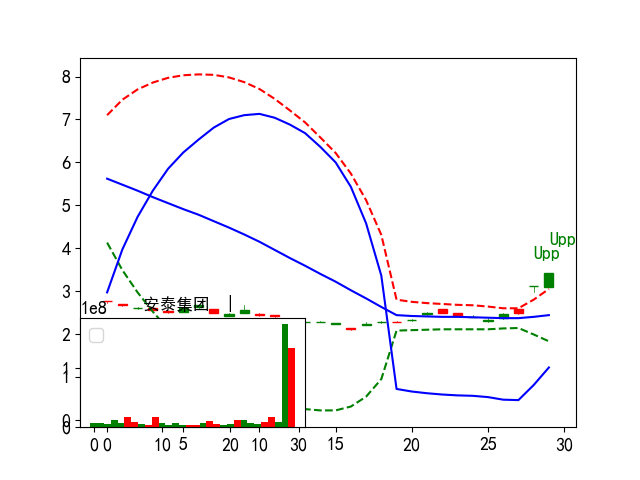

002375 1.2
xratio:0.01 ra_diff:1.2


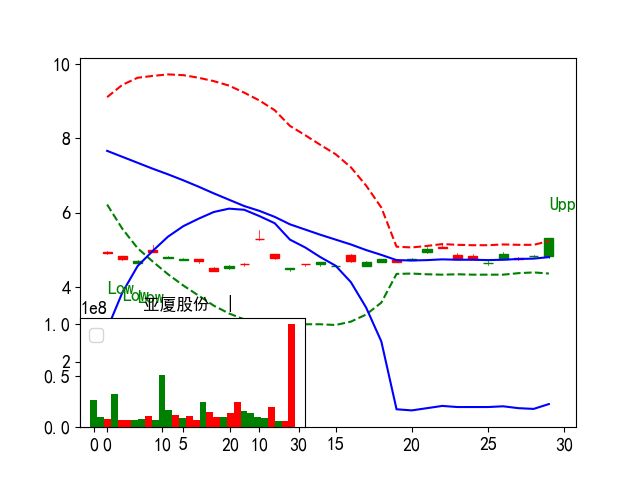

300006 1.3
xratio:-0.01 ra_diff:1.3


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


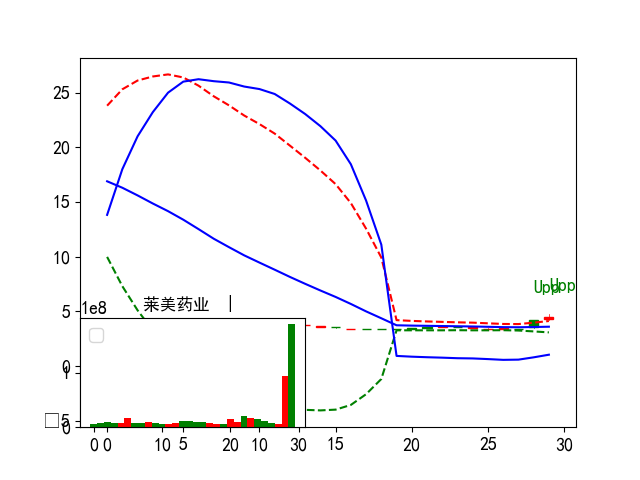

600189 1.69
xratio:0.08 ra_diff:1.69


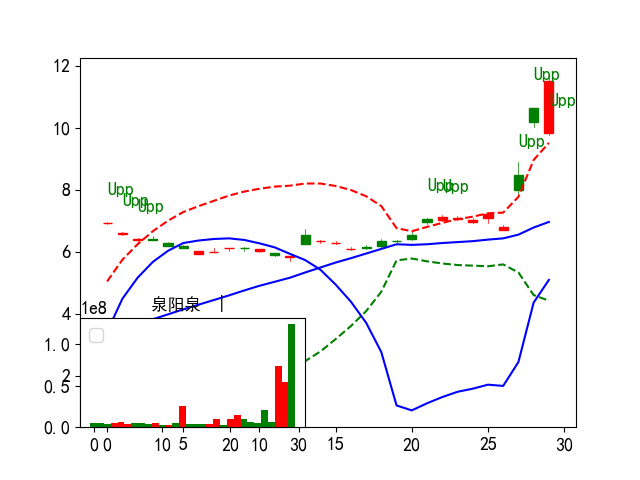

605088 1.55
xratio:0.11 ra_diff:1.55


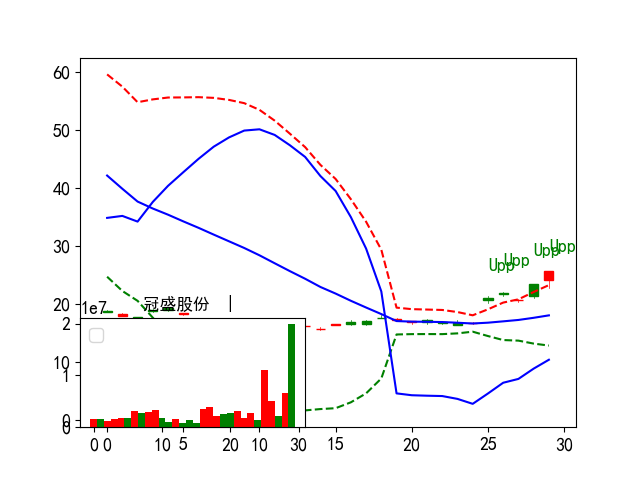

002406 1.34
xratio:0.01 ra_diff:1.34


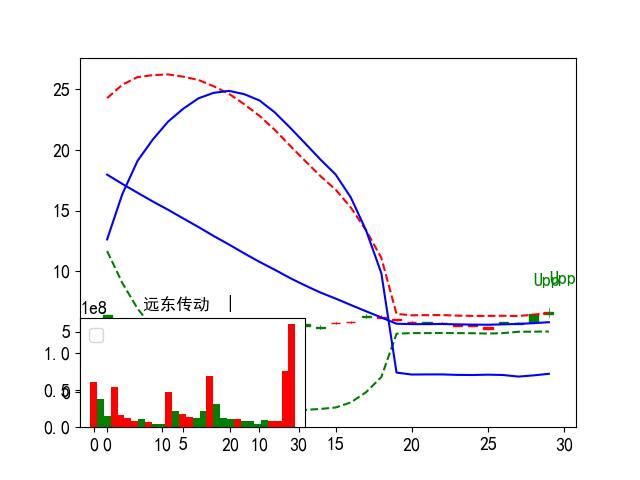

001268 1.84
xratio:0.12 ra_diff:1.84


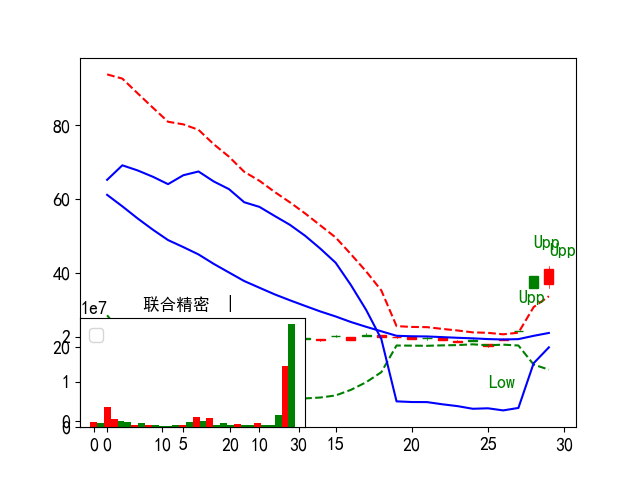

002889 1.58
xratio:-0.18 ra_diff:1.58


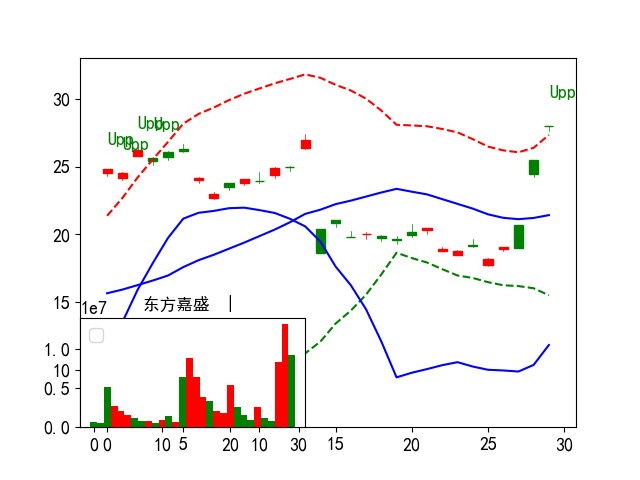

002547 1.43
xratio:-0.01 ra_diff:1.43


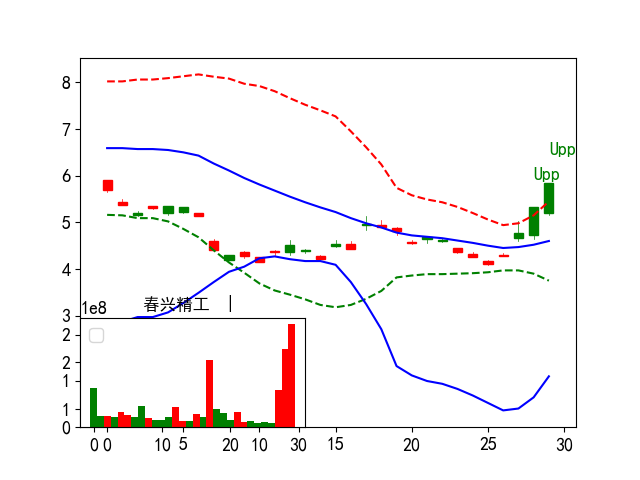

In [76]:
print("df_mask_hmax:%s"%(len(df_mask_hmax)))
for co in df_mask_hmax.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfs.loc[co][-60:],code=co)

###  df_masklastd 068
    show_ohlc_upper(dfs.loc[co][-60:])

df_masklastd:109
300293 1.94
xratio:0.09 ra_diff:1.94


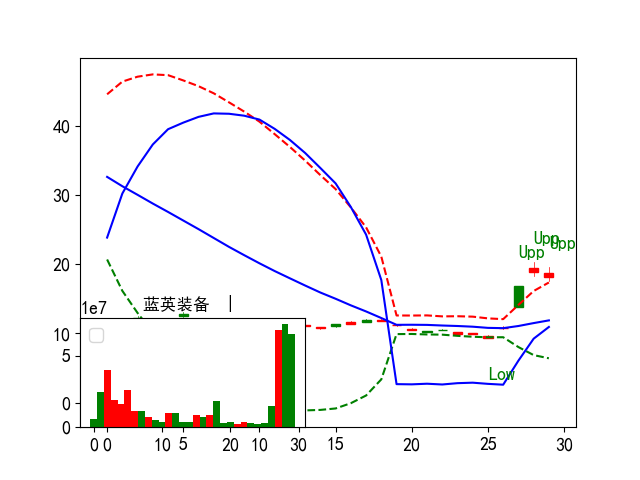

000536 1.92
xratio:0.02 ra_diff:1.92


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


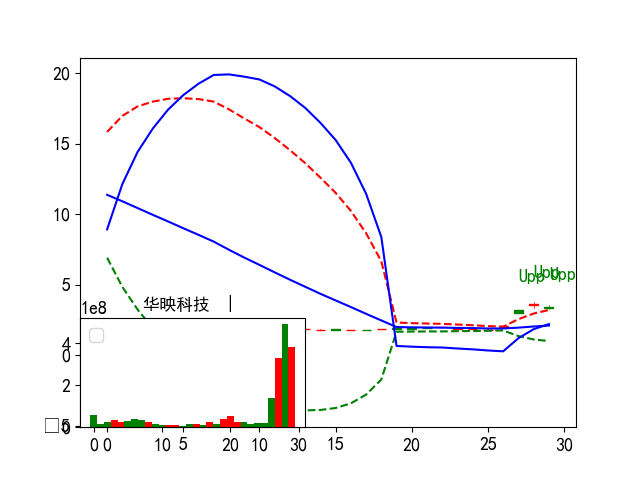

002855 3.0
xratio:0.28 ra_diff:3.0


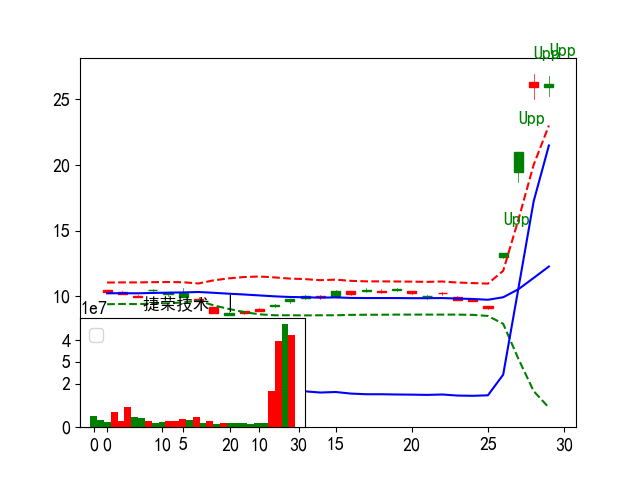

000766 2.9
xratio:0.13 ra_diff:2.9


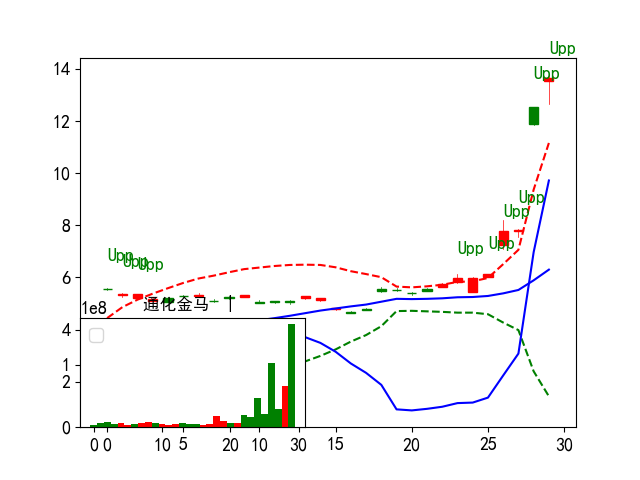

603326 1.69
xratio:0.08 ra_diff:1.69


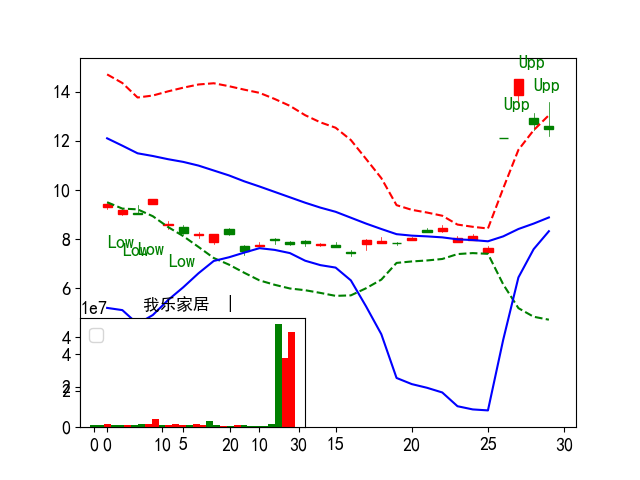

000046 3.24
xratio:0.04 ra_diff:3.24


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


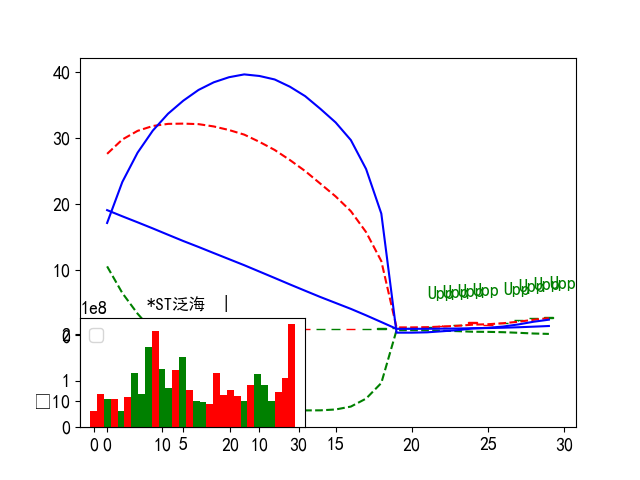

001268 1.84
xratio:0.12 ra_diff:1.84


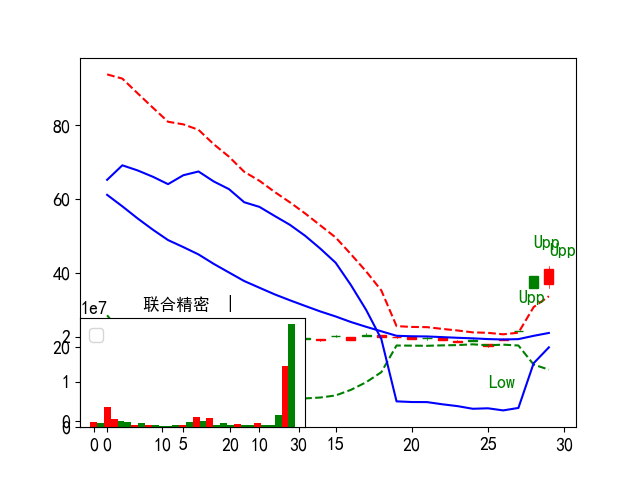

301169 1.42
xratio:0.4 ra_diff:1.42


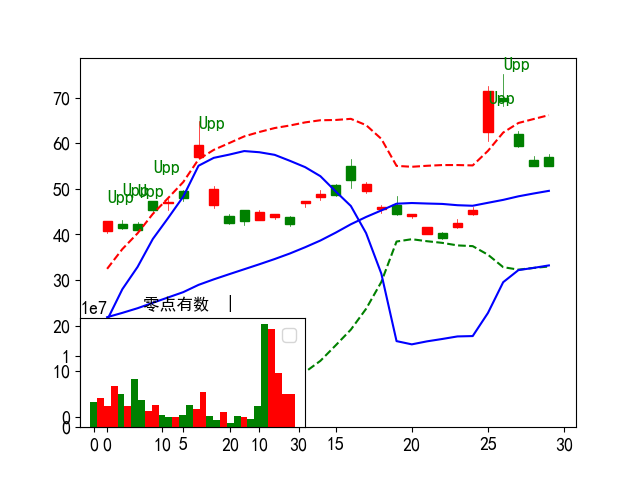

601188 1.61
xratio:0.02 ra_diff:1.61


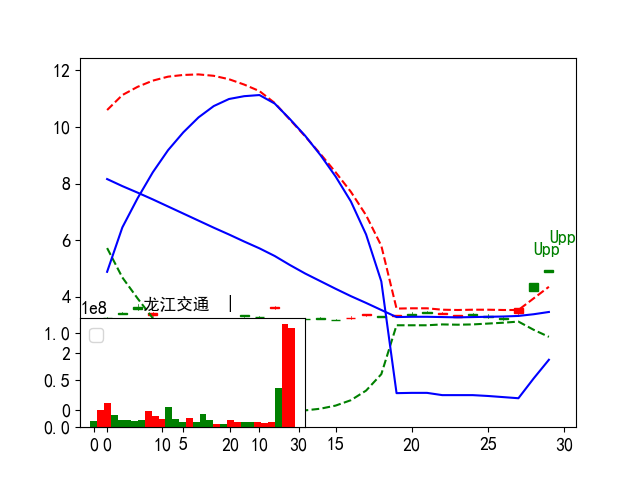

002889 1.58
xratio:-0.18 ra_diff:1.58


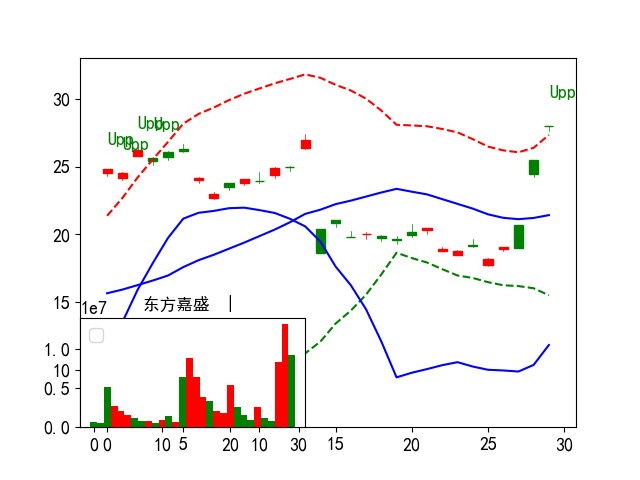

In [77]:
print("df_masklastd:%s"%(len(df_masklastd)))
for co in df_masklastd.index[:10]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfs.loc[co][-60:],code=co)

### Cross_hmax_250 068

In [78]:
# dfs.loc[code_t].ma5
cross_hmax_250 = [co for co in df_masklastd.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))
show_tdx_data(df_masklastd.loc[cross_hmax_250])

cross_hamx:36
Count:36 40


name  couts       date   perc  ra_diff  xratio    idx    hat  close  \
code                                                                           
000766   通化金马      4 2023-09-22  -1.33     2.90    0.20   8.13   9.72  13.34   
000046  *ST泛海      2 2023-09-15   5.02     3.15    0.06   1.55   2.09   2.93   
001268   联合精密      2 2023-09-22 -10.00     1.84    0.30  14.92  19.88  33.30   
601188   龙江交通      1 2023-09-22   9.94     1.61    0.03   1.54   1.77   5.42   
002889   东方嘉盛      1 2023-09-22  -9.99     1.58   -0.13   7.83  11.84  25.23   
600599   ST熊猫      1 2023-09-15   1.73     1.44   -0.11   2.56   3.37  12.95   
300049   福瑞股份      1 2023-09-22  -6.19     1.79   -0.15  16.00  17.08  34.99   
600408   安泰集团      1 2023-09-22  -9.94     1.62    0.01   1.10   1.22   3.08   
002547   春兴精工      2 2023-09-22  -2.05     1.43    0.02   1.30   1.70   5.73   
601666   平煤股份      1 2023-09-15  -1.75     1.48   -0.05   3.10   4.16  10.65   
603949   雪龙集团      5 2023-09-22   0.08     1.74    0.32   8.47  11.89  24.72   
000058  深 赛 格      3 2023-09-22 -10.02     1.38    0.06   1.69   2.57   7.45   
300006   莱美药业      1 2023-09-22  -5.53     1.30   -0.00   0.87   1.04   4.10   
002693   双成药业      1 2023-09-22   0.36     1.45    0.03   2.14   2.45   8.30   
600203   福日电子      2 2023-09-22 -10.04     1.43    0.01   1.93   2.07   7.08   
600546   山煤国际      3 2023-09-15   0.73     1.46    0.09   3.67   6.51  19.45   
605128   上海沿浦      1 2023-09-22   1.03     1.46    0.50   8.45  15.96  51.12   
000010   美丽生态      1 2023-08-25   6.96     1.64    0.00   1.33   1.31   3.69   
000962   东方钽业      2 2023-09-22  -9.97     1.37    0.07   2.55   4.17  13.19   
300606    金太阳      1 2023-09-22   0.66     2.06    0.41   9.52  12.61  27.47   
000637   ST实华      1 2023-09-22   1.49     1.27   -0.02   0.70   0.79   4.08   
001319   铭科精技      1 2023-09-22   9.99     1.26    0.08   3.66   4.33  26.32   
002406   远东传动      1 2023-09-22  -4.52     1.34    0.04   0.86   1.53   6.34   
300840   酷特智能      2 2023-09-22  -4.07     1.70    0.14   3.66   5.49  15.54   
000428   华天酒店      2 2023-09-22  -5.19     1.35    0.02   1.19   1.64   5.30   
605088   冠盛股份      3 2023-09-22  -7.62     1.55    0.27   7.31  10.41  22.31   
603160   汇顶科技      3 2023-09-22  -3.63     1.41    0.40   9.04  23.33  62.64   
002826   易明医药      1 2023-09-22   9.99     1.17    0.00   1.06   1.67  12.88   
300796    贝斯美      4 2023-09-22  -1.00     1.28    0.04   2.75   3.27  13.85   
300735   光弘科技      1 2023-09-22  -3.39     1.23    0.02   1.42   2.36  11.67   
603903   中持股份      1 2023-09-01   0.82     1.11   -0.01   0.78   0.88   9.84   
605068   明新旭腾      3 2023-09-22   3.25     1.31    0.14   4.42   7.00  27.98   
603059    倍加洁      1 2023-09-22  -3.50     1.21    0.04   2.16   4.37  24.52   
002287   奇正藏药      1 2023-09-22  -0.91     1.12   -0.05   2.10   2.83  25.15   
002750   龙津药业      2 2023-09-22  -1.99     1.25    0.03   1.90   2.46  10.86   
301096   百诚医药      1 2023-09-22  -0.52     1.10   -0.16   5.50   6.01  64.67   

        volsum5d  ...   ma20  nclose   llow   vol1d    vol2d    vol3d   vol4d  \
code              ...                                                           
000766     548.4  ...   6.30   13.37  12.65  153.70   124.57   -71.85  397.81   
000046      41.9  ...   1.34    2.92   2.64   37.52    35.90   -38.44  -20.34   
001268     992.1  ...  23.78   34.69  36.02   70.40   403.89   583.33  -34.09   
601188     793.8  ...   3.46    5.42   4.87   -4.07   163.46   629.08   20.55   
002889     945.4  ...  21.43   25.65  27.61  -29.80    58.20  1007.38  -35.93   
600599     493.0  ...  10.95   12.96  12.89  -14.41   -49.31   629.46  -65.06   
300049     315.2  ...  25.81   35.11  31.10  202.11   -10.62     0.93  157.93   
600408    2034.4  ...   2.44    3.10   3.10  -23.81  1948.87   -50.87   83.90   
002547     932.5  ...   4.60    5.82   5.16   32.38   112.83   795.27  -16.67   
601666     314.8  ...   8.45   10.72  10.73   81.22   -58.84   248.97  -27.03

df_mask250:36
603160 1.41
xratio:0.1 ra_diff:1.41


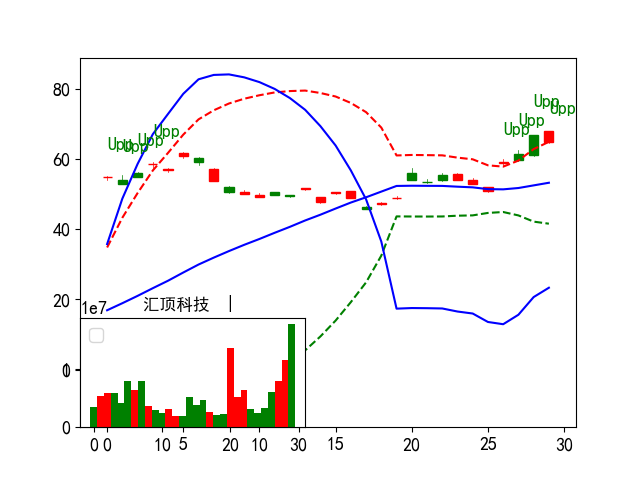

002826 1.17
xratio:-0.01 ra_diff:1.17


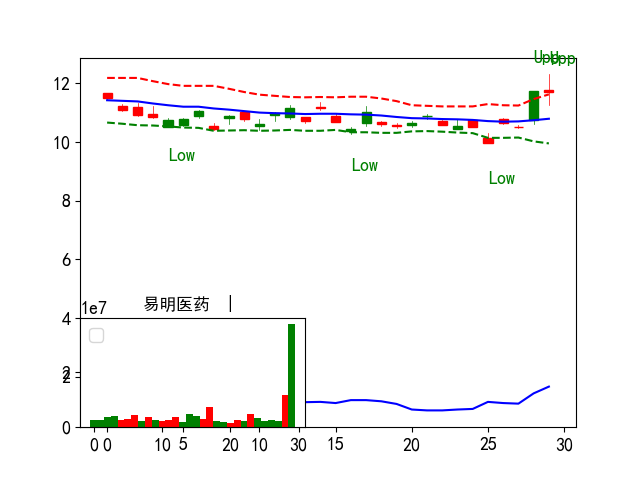

300796 1.28
xratio:-0.36 ra_diff:1.28


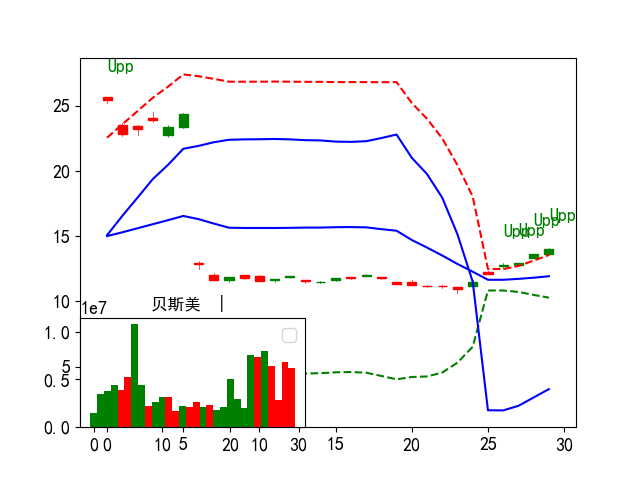

300735 1.23
xratio:-0.01 ra_diff:1.23


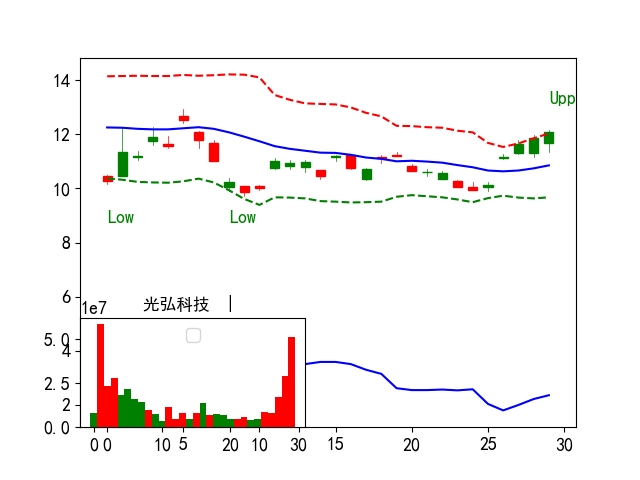

603903 1.12
xratio:-0.01 ra_diff:1.12


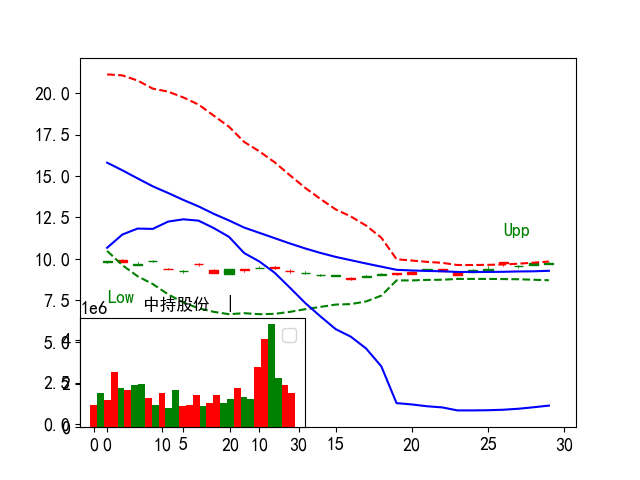

605068 1.31
xratio:-0.05 ra_diff:1.31


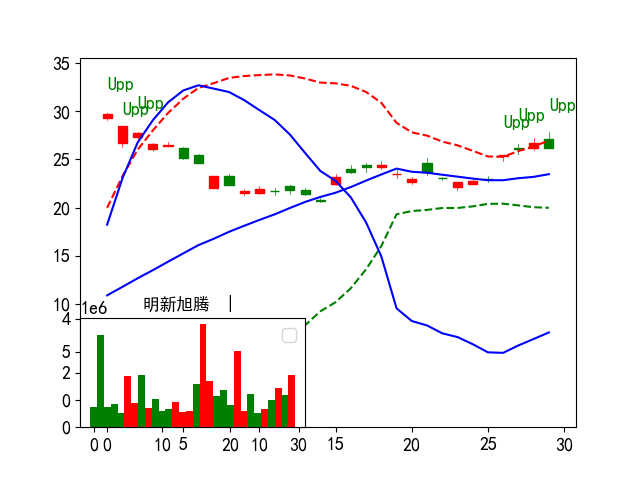

603059 1.21
xratio:-0.02 ra_diff:1.21


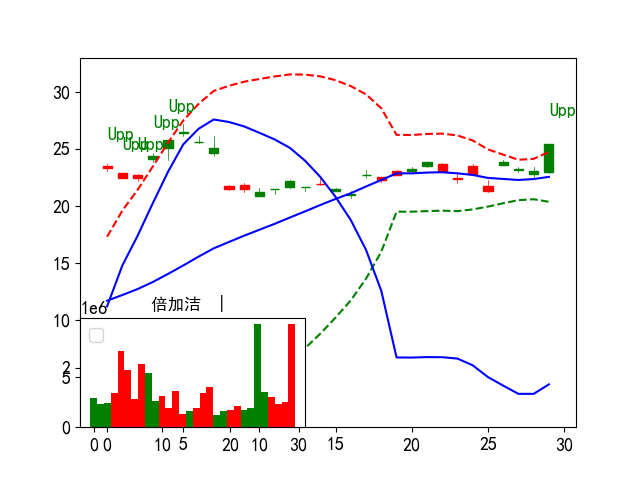

002287 1.12
xratio:-0.06 ra_diff:1.12


C:\Users\Johnson\anaconda3\lib\site-packages\ipympl\backend_nbagg.py:336: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self.figure.savefig(buf, format='png', dpi='figure')


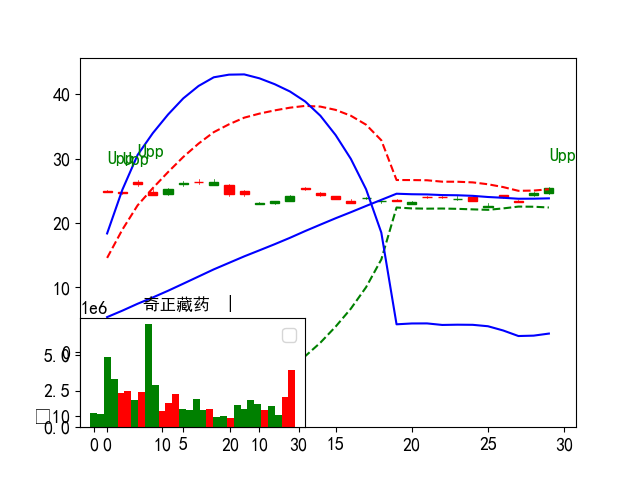

002750 1.25
xratio:-0.03 ra_diff:1.25


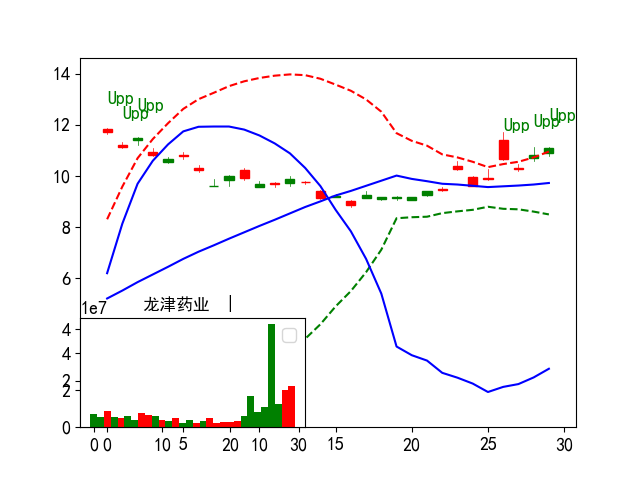

301096 1.1
xratio:-0.2 ra_diff:1.1


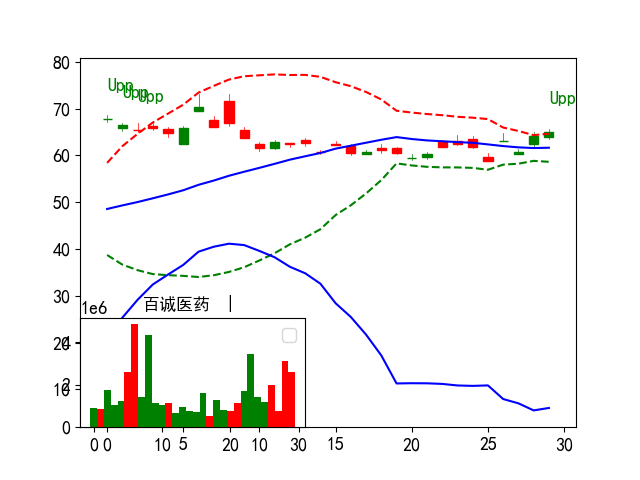

In [79]:
print("df_mask250:%s"%(len(cross_hmax_250)))
for co in cross_hmax_250[-10:]:
    print(co,dfs.loc[co].ra_diff[-1])
    show_ohlc_upper(dfs.loc[co][-60:],code=co)

## 写入061

In [80]:
# write_code_to_blk(df_masklastd.index.tolist(),'061')
# hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) & (df_mask_hmax.volsum5d > 10) & (df_mask_hmax.volsum5d < 150)].index.tolist()
hmax_code = df_mask_hmax[(df_mask_hmax.couts > 1) ].index.tolist()

# write_code_to_blk(cross_hmax_250,'068')
# write_code_to_blk(hmax_code,'061')

In [81]:
# print(df_masklastd.loc['301255'].date)

# 默认年线筛选

In [82]:
top_temp.shape
top_temp.index

(25, 33)

Index(['600186', '000766', '002855', '300045', '603326', '603767', '605088',
       '300293', '603949', '600895', '600189', '300537', '300049', '000536',
       '605588', '002889', '605365', '603607', '601666', '601188', '600408',
       '300765', '300331', '300255', '001268'],
      dtype='object', name='code')

## plt.close('all')

In [83]:
# plt.close('all')

# 写入060